# Frenet on Carla

In [1]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

In [2]:
from util.carla_util import carla_vec_to_np_array, carla_img_to_array, CarlaSyncMode, find_weather_presets, get_font, should_quit #draw_image
from util.geometry_util import dist_point_linestring

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import random
import cv2
from pathlib import Path
import numpy as np
import pygame
import math
import weakref
import pickle
import copy
from typing import List

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# from util.carla_util import carla_vec_to_np_array, carla_img_to_array, CarlaSyncMode, find_weather_presets, get_font, should_quit #draw_image
# from util.geometry_util import dist_point_linestring


In [4]:
from quintic_polynomials_planner import QuinticPolynomial
import cubic_spline_planner

In [5]:

from frenet_optimal_trajectory import FrenetPlanner as MotionPlanner

import imageio
from copy import deepcopy

In [6]:
optimalDistance = 8
followDrivenPath = True
evaluateChasingCar = True
record = False
chaseMode = True
followMode = False

drivesDir = './drives'
drivesFileNames = os.listdir(drivesDir)
drivesFileNames.sort()

drivesFileNames = ['ride5.p']  #   ['ride8.p']  ['ride10.p']  for testing advance angle turns # turnel ['ride15.p']  


In [7]:
def send_control(vehicle, throttle, steer, brake,
                 hand_brake=False, reverse=False):
    throttle = np.clip(throttle, 0.0, 1.0)
    steer = np.clip(steer, -1.0, 1.0)
    brake = np.clip(brake, 0.0, 1.0)
    control = carla.VehicleControl(throttle, steer, brake, hand_brake, reverse)
    vehicle.apply_control(control)


def get_speed(vehicle):
    """
    Compute speed of a vehicle in Kmh
    :param vehicle: the vehicle for which speed is calculated
    :return: speed as a float in Kmh
    """
    vel = vehicle.get_velocity()
    # return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)        # 3.6 * meter per seconds = kmh
    return math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)        # meter per seconds



In [8]:

# New Classes
class Evaluation():
    def __init__(self):
        self.sumMAE = 0
        self.sumRMSE = 0
        self.n_of_frames = 0
        self.n_of_collisions = 0
        self.history = []

    def AddError(self, distance, goalDistance):
        self.n_of_frames += 1
        self.sumMAE += abs(goalDistance-distance)
        self.sumRMSE += abs(goalDistance-distance)*abs(goalDistance-distance)

    def WriteIntoFileFinal(self, filename, driveName):
        if self.n_of_frames > 0:
            self.sumMAE = self.sumMAE / float(self.n_of_frames)
            self.sumRMSE = self.sumRMSE / float(self.n_of_frames)

        with open(filename,'a') as f:
            f.write(str(driveName)+', '+str(self.sumMAE)+', '+str(self.sumRMSE)+', '+str(self.n_of_collisions)+'\n')

    def LoadHistoryFromFile(self, fileName):
        self.history = pickle.load( open(fileName, "rb"))

    def CollisionHandler(self,event):
        self.n_of_collisions += 1


class LineOfSightSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self.distance = None
        self.vehicle_ahead = None
        self._parent = parent_actor
        # self.sensor_transform = carla.Transform(carla.Location(x=4, z=1.7), carla.Rotation(yaw=0)) # Put this sensor on the windshield of the car.
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.obstacle')
        bp.set_attribute('distance', '200')
        bp.set_attribute('hit_radius', '0.5')
        bp.set_attribute('only_dynamics', 'True')
        bp.set_attribute('debug_linetrace', 'True')
        bp.set_attribute('sensor_tick', '0.0')
        self.sensor = world.spawn_actor(bp, carla.Transform(), attach_to=self._parent)
        weak_self = weakref.ref(self)
        self.sensor.listen(lambda event: LineOfSightSensor._on_los(weak_self, event))

    def reset(self):
        self.vehicle_ahead = None
        self.distance = None

    def destroy(self):
        self.sensor.destroy()

    def get_vehicle_ahead(self):
        return self.vehicle_ahead

    # Only works for CARLA 9.6 and above!
    def get_los_distance(self):
        return self.distance

    @staticmethod
    def _on_los(weak_self, event):
        self = weak_self()
        if not self:
            return
        self.vehicle_ahead = event.other_actor
        self.distance = event.distance



In [9]:
class QuarticPolynomial:

    def __init__(self, xs, vxs, axs, vxe, axe, time):
        # calc coefficient of quartic polynomial

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[3 * time ** 2, 4 * time ** 3],
                      [6 * time, 12 * time ** 2]])
        b = np.array([vxe - self.a1 - 2 * self.a2 * time,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]

    def calc_point(self, t):
        xt = self.a0 + self.a1 * t + self.a2 * t ** 2 + \
             self.a3 * t ** 3 + self.a4 * t ** 4

        return xt

    def calc_first_derivative(self, t):
        xt = self.a1 + 2 * self.a2 * t + \
             3 * self.a3 * t ** 2 + 4 * self.a4 * t ** 3

        return xt

    def calc_second_derivative(self, t):
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t ** 2

        return xt

    def calc_third_derivative(self, t):
        xt = 6 * self.a3 + 24 * self.a4 * t

        return xt

In [10]:
def calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0):
    frenet_paths = []

    # generate path to each offset goal
    for di in np.arange(-MAX_ROAD_WIDTH, MAX_ROAD_WIDTH, D_ROAD_W):

        # Lateral motion planning
        for Ti in np.arange(MIN_T, MAX_T, DT):
            fp = FrenetPath()

            lat_qp = QuinticPolynomial(c_d, c_d_d, c_d_dd, di, 0.0, 0.0, Ti)

            fp.t = [t for t in np.arange(0.0, Ti, DT)]
            fp.d = [lat_qp.calc_point(t) for t in fp.t]
            fp.d_d = [lat_qp.calc_first_derivative(t) for t in fp.t]
            fp.d_dd = [lat_qp.calc_second_derivative(t) for t in fp.t]
            fp.d_ddd = [lat_qp.calc_third_derivative(t) for t in fp.t]

            # Longitudinal motion planning (Velocity keeping)
            for tv in np.arange(TARGET_SPEED - D_T_S * N_S_SAMPLE,
                                TARGET_SPEED + D_T_S * N_S_SAMPLE, D_T_S):
                tfp = copy.deepcopy(fp)
                lon_qp = QuarticPolynomial(s0, c_speed, 0.0, tv, 0.0, Ti)

                tfp.s = [lon_qp.calc_point(t) for t in fp.t]
                tfp.s_d = [lon_qp.calc_first_derivative(t) for t in fp.t]
                tfp.s_dd = [lon_qp.calc_second_derivative(t) for t in fp.t]
                tfp.s_ddd = [lon_qp.calc_third_derivative(t) for t in fp.t]

                Jp = sum(np.power(tfp.d_ddd, 2))  # square of jerk
                Js = sum(np.power(tfp.s_ddd, 2))  # square of jerk

                # square of diff from target speed
                ds = (TARGET_SPEED - tfp.s_d[-1]) ** 2

                tfp.cd = K_J * Jp + K_T * Ti + K_D * tfp.d[-1] ** 2
                tfp.cv = K_J * Js + K_T * Ti + K_D * ds
                tfp.cf = K_LAT * tfp.cd + K_LON * tfp.cv

                frenet_paths.append(tfp)

    return frenet_paths






In [11]:
def check_paths(fplist, ob):
    ok_ind = []
    for i, _ in enumerate(fplist):
        if any([v > MAX_SPEED for v in fplist[i].s_d]):  # Max speed check
            continue
        elif any([abs(a) > MAX_ACCEL for a in
                  fplist[i].s_dd]):  # Max accel check
            continue
        elif any([abs(c) > MAX_CURVATURE for c in
                  fplist[i].c]):  # Max curvature check
            continue
        elif not check_collision(fplist[i], ob):
            continue

        ok_ind.append(i)

    return [fplist[i] for i in ok_ind]

In [12]:
def check_collision(fp, ob):
    for i in range(len(ob[:, 0])):
        d = [((ix - ob[i, 0]) ** 2 + (iy - ob[i, 1]) ** 2)
             for (ix, iy) in zip(fp.x, fp.y)]

        collision = any([di <= ROBOT_RADIUS ** 2 for di in d])

        if collision:
            return False

    return True


In [13]:
# Frenet imports

from cubic_spline_planner import *

def generate_target_course(x, y, z):
    csp = Spline3D(x, y, z)
    s = np.arange(0, csp.s[-1], 0.1)

    rx, ry, rz, ryaw, rk = [], [], [], [], []
    for i_s in s:
        ix, iy, iz = csp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        rz.append(iz)
        ryaw.append(csp.calc_yaw(i_s))
        rk.append(csp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, csp

In [14]:
def frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob):
    fplist = calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0)
    fplist = calc_global_paths(fplist, csp)
    fplist = check_paths(fplist, ob)

    # find minimum cost path
    min_cost = float("inf")
    best_path = None
    for fp in fplist:
        if min_cost >= fp.cf:
            min_cost = fp.cf
            best_path = fp

    return best_path

In [15]:

def frenet_to_inertial(s, d, csp):
    """
    transform a point from frenet frame to inertial frame
    input: frenet s and d variable and the instance of global cubic spline class
    output: x and y in global frame
    """
    ix, iy, iz = csp.calc_position(s)
    iyaw = csp.calc_yaw(s)
    x = ix + d * math.cos(iyaw + math.pi / 2.0)
    y = iy + d * math.sin(iyaw + math.pi / 2.0)

    return x, y, iz, iyaw

In [16]:
class FrenetPath:

    def __init__(self):
        self.t = []
        self.d = []
        self.d_d = []
        self.d_dd = []
        self.d_ddd = []
        self.s = []
        self.s_d = []
        self.s_dd = []
        self.s_ddd = []
        self.cd = 0.0
        self.cv = 0.0
        self.cf = 0.0

        self.x = []
        self.y = []
        self.z = []
        self.yaw = []
        self.ds = []
        self.c = []

        self.v = []  # speed

In [17]:
SIM_LOOP = 500

# Parameter
MAX_SPEED = 20.0 / 3.6  # maximum speed [m/s]
MAX_ACCEL = 2.0  # maximum acceleration [m/ss]
MAX_CURVATURE = 0.5  # maximum curvature [1/m]
MAX_ROAD_WIDTH = 10 #7  # maximum road width [m]
D_ROAD_W = 1.0 # 1.0  # road width sampling length [m]
DT = 0.2 #0.2 # time tick [s]
MAX_T = 6.0  # max prediction time [m]
MIN_T = 3.0  # min prediction time [m]
TARGET_SPEED = 10.0 / 3.6  # target speed [m/s]
D_T_S = 5.0 / 3.6  # target speed sampling length [m/s]
N_S_SAMPLE = 1  # sampling number of target speed
ROBOT_RADIUS = 2.2  # robot radius [m]

# cost weights
K_J = 0.1
K_T = 0.1
K_D = 1.0
K_LAT = 1.0
K_LON = 1.0


show_animation = True

In [18]:
from IPython import display as ipython_display
import pylab as pl

In [19]:
# def main(optimalDistance, followDrivenPath, chaseMode, evaluateChasingCar, driveName='',record=False, followMode=False,
#          resultsName='results',P=None,I=None,D=None,nOfFramesToSkip=0):
#     # Imports
#     # from cores.lane_detection.lane_detector import LaneDetector
#     # from cores.lane_detection.camera_geometry import CameraGeometry
#     # from cores.control.pure_pursuit import PurePursuitPlusPID

#     # New imports
#     from DrivingControl import DrivingControl
#     from DrivingControlAdvanced import DrivingControlAdvanced
#     from CarDetector import CarDetector
#     from SemanticSegmentation import SemanticSegmentation


#     # New Variables
#     extrapolate = True
#     optimalDistance = 2
#     followDrivenPath = True
#     evaluateChasingCar = True
#     record = False
#     chaseMode = True
#     followMode = False
#     counter = 1
#     sensors = []

#     vehicleToFollowSpawned = False
#     obsticle_vehicleSpawned = False

#     # New objects
#     carDetector = CarDetector()
#     drivingControl = DrivingControl(optimalDistance=optimalDistance)
#     drivingControlAdvanced = DrivingControlAdvanced(optimalDistance=optimalDistance)
#     evaluation = Evaluation()
#     semantic = SemanticSegmentation()


#     actor_list = []
#     pygame.init()

# #     display = pygame.display.set_mode(
# #         (800, 600),
# #         pygame.HWSURFACE | pygame.DOUBLEBUF)
#     font = get_font()
#     clock = pygame.time.Clock()

#     client = carla.Client('localhost', 2000)
#     client.set_timeout(80.0)

#     #client.load_world('Town06')
#     # client.load_world('Town04')
#     world = client.get_world()
#     weather_presets = find_weather_presets()
#     # print(weather_presets)
#     world.set_weather(weather_presets[3][0])
#     # world.set_weather(carla.WeatherParameters.HardRainSunset)

#     # controller = PurePursuitPlusPID()

# #     # Set BirdView
# #     birdview_producer = BirdViewProducer(
# #         client,
# #         PixelDimensions(width=DEFAULT_WIDTH, height=DEFAULT_HEIGHT),
# #         pixels_per_meter=4,
# #         crop_type=BirdViewCropType.FRONT_AND_REAR_AREA,
# #         render_lanes_on_junctions=False,
# #     )


#     try:
#         m = world.get_map()

#         blueprint_library = world.get_blueprint_library()

#         veh_bp = random.choice(blueprint_library.filter('vehicle.dodge_charger.police'))
#         vehicle = world.spawn_actor(
#             veh_bp,
#             m.get_spawn_points()[90])
#         actor_list.append(vehicle)

#         # New vehicle property
#         vehicle.set_simulate_physics(True)

#         if followDrivenPath:
#             evaluation.LoadHistoryFromFile(driveName)
#             first = evaluation.history[0]
#             start_pose = carla.Transform(carla.Location(first[0], first[1], first[2]),
#                                         carla.Rotation(first[3], first[4], first[5]))
#             vehicle.set_transform(start_pose)

#         # New Sensors
#         collision_sensor = world.spawn_actor(blueprint_library.find('sensor.other.collision'),
#                                                 carla.Transform(), attach_to=vehicle)
#         collision_sensor.listen(lambda event: evaluation.CollisionHandler(event))
#         actor_list.append(collision_sensor)

        
#         # front cam for object detection
#         camera_rgb_blueprint = world.get_blueprint_library().find('sensor.camera.rgb')
#         camera_rgb_blueprint.set_attribute('fov', '90')
#         camera_rgb = world.spawn_actor(
#            camera_rgb_blueprint,
#             carla.Transform(carla.Location(x=1.5, z=1.4,y=0.3), carla.Rotation(pitch=0)),
#             attach_to=vehicle)
#         actor_list.append(camera_rgb)
#         sensors.append(camera_rgb)

            
#         # segmentation camera
#         camera_segmentation = world.spawn_actor(
#             blueprint_library.find('sensor.camera.semantic_segmentation'),
#             carla.Transform(carla.Location(x=1.5, z=1.4,y=0), carla.Rotation(pitch=0)), #5,3,0 # -0.3
#             attach_to=vehicle)
#         actor_list.append(camera_segmentation)
#         sensors.append(camera_segmentation)


        
#         # Set up local planner and behavnioural planner
#         # --------------------------------------------------------------

#         print("vehicle.get_transform():", vehicle.get_transform())
        

#         # Start Modules
   

#         # --------------------------------------------------------------


#         frame = 0
#         max_error = 0
#         FPS = 30
#         speed = 0
#         cross_track_error = 0
#         start_time = 0.0
#         times = 8
#         LP_FREQUENCY_DIVISOR   = 8                # Frequency divisor to make the 
#                                                 # local planner operate at a lower
#                                                 # frequency than the controller
#                                                 # (which operates at the simulation
#                                                 # frequency). Must be a natural
#                                                 # number.
                            


#         actors_batch = []
        
#         print("Len of waypoints:" , len(evaluation.history))
        
        
                
#         # TMP obstacle lists
#         ob = np.array([
#                        [233.980630, 60.523910],
#                        [233.980630, 80.523910],
#                        [233.980630, 100.523910],
#                        [233.786942, 110.530586],
#                        ])
        
        
#         def look_ahead_local_planer(waypoints: List, current_idx: int=0, look_ahead: int=20 ):
            
#             wx = []
#             wy = []
#             wz = []

#             for p in waypoints[current_idx: (current_idx + look_ahead)]:
#                 wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
#                 wx.append(wp.location.x)
#                 wy.append(wp.location.y)
#                 wz.append(wp.location.z)

# #             print("wx: ", wx)
#             tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)
            
#             return csp
        
        
                    
#         wx = []
#         wy = []
#         wz = []

#         for p in evaluation.history:
#             wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
#             wx.append(wp.location.x)
#             wy.append(wp.location.y)
#             wz.append(wp.location.z)


#         tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)


                
#         # initial state
#         c_speed = 10.0 / 3.6  # current speed [m/s]
#         c_d = 2.0  # current lateral position [m]
#         c_d_d = 0.0  # current lateral speed [m/s]
#         c_d_dd = 0.0  # current latral acceleration [m/s]
#         s0 = 0.0  # current course position    
        
#         trail_c_speed = 10.0 / 3.6  # current speed [m/s]
#         trail_c_d = 2.0  # current lateral position [m]
#         trail_c_d_d = 0.0  # current lateral speed [m/s]
#         trail_c_d_dd = 0.0  # current latral acceleration [m/s]
#         trail_s0 = 0.0  # current course position    
        
        
#         area = 40.0  # animation area length [m]

#         fig = plt.figure()
        
        
#         # other actors
#         other_actor_ids = []
        
        
#         # Leading waypoints 
#         leading_waypoints = []
     
        
#         i = 0
        
#         # Create a synchronous mode context.
#         with CarlaSyncMode(world, *sensors, fps=FPS) as sync_mode:
#             while i <400:
#                 if should_quit():
#                     return
        
#                 # snapshot, image_rgb, image_segmentation = tick_response
#                 snapshot, img_rgb, image_segmentation = sync_mode.tick(timeout=2.0)

#                 # detect car in image with semantic segnmentation camera
#                 carInTheImage = semantic.IsThereACarInThePicture(image_segmentation)

#                 line = []

#                 # ------------------- Set up leading vehicle --------------------------------
#                 # Spawn a vehicle to follow
#                 if not vehicleToFollowSpawned and followDrivenPath:
#                     vehicleToFollowSpawned = True
#                     location1 = vehicle.get_transform()
#                     newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,
#                                                                      location1.rotation.yaw)
#                     diffX = newX - location1.location.x
#                     diffY = newY - location1.location.y
#                     newX = location1.location.x - (diffX*5)
#                     newY = location1.location.y - (diffY*5)

#                     start_pose.location.x = newX
#                     start_pose.location.y = newY

#                     vehicle.set_transform(start_pose)

#                     start_pose2 = random.choice(m.get_spawn_points())

#                     bp = blueprint_library.filter('model3')[0]
#                     bp.set_attribute('color', '0,101,189')
#                     vehicleToFollow = world.spawn_actor(
#                         bp,
#                         start_pose2)

#                     start_pose2 = carla.Transform()
#                     start_pose2.rotation = start_pose.rotation

#                     start_pose2.location.x = start_pose.location.x
#                     start_pose2.location.y = start_pose.location.y
#                     start_pose2.location.z = start_pose.location.z

#                     vehicleToFollow.set_transform(start_pose2)

#                     actor_list.append(vehicleToFollow)
#                     vehicleToFollow.set_simulate_physics(True)

#                 # ------------------- --------------------------------

#                 if followDrivenPath:
#                     if counter >= len(evaluation.history):
#                         break
#                     tmp = evaluation.history[counter]
#                     currentPos = carla.Transform(carla.Location(tmp[0] ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
#                     vehicleToFollow.set_transform(currentPos)
#                     counter += 1




#     #             # Adding obsticle_vehicle to actors_batch
#     #             los_sensor = LineOfSightSensor(obsticle_vehicle)

#     #             target_speed = get_speed(obsticle_vehicle)


#                 tmp = evaluation.history[i-1]
#                 currentPos = carla.Transform(carla.Location(tmp[0] + 0 ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
#                 vehicleToFollow.set_transform(currentPos)



#                 # ------------------- Set up obsticle vehicle for testing  --------------------------------

#                 # Set up obsticle vehicle for testing 
  
#                 if not obsticle_vehicleSpawned and followDrivenPath:
#                     obsticle_vehicleSpawned = True
            
#                     for obsticle_p in ob:

#                         start_pose3 = random.choice(m.get_spawn_points())

#                         obsticle_vehicle = world.spawn_actor(
#                         random.choice(blueprint_library.filter('jeep')),
#                         start_pose3)

#                         start_pose3 = carla.Transform()
#                         start_pose3.rotation = start_pose2.rotation
#                         start_pose3.location.x = obsticle_p[0] 
#                         start_pose3.location.y =  obsticle_p[1]
#                         start_pose3.location.z =  start_pose2.location.z

#                         obsticle_vehicle.set_transform(start_pose3)
#                         obsticle_vehicle.set_autopilot(True)

        
#                         actor_list.append(obsticle_vehicle)
#                         obsticle_vehicle.set_simulate_physics(True)
                
                
#                         other_actor_ids.append(obsticle_vehicle.id)
                    
                        
                        
                        



#                 # ------------------- --------------------------------
                
#                 #---- Leading Frenet -----------------------------
                
#                 path = frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob)
                
#                 # Testing dynamic obsticles

# #                 ob[2][0] = ob[2][0] - 0.05
# #                 ob[3][1] = ob[3][1] + 0.5 # charing will be difficult 
# #                 ob[4][1] = ob[4][1] + 0.2


#                 ob = np.array([ [actor.get_transform().location.x,actor.get_transform().location.y] for actor in actor_list if actor.id in other_actor_ids ])

#                 print("new ob: ", ob)

                
#                 new_vehicleToFollow_transform = carla.Transform()
#                 new_vehicleToFollow_transform.rotation =  carla.Rotation(pitch=0.0, yaw=math.degrees(path.yaw[1]), roll=0.0) 
    
#                 new_vehicleToFollow_transform.location.x = path.x[1]
#                 new_vehicleToFollow_transform.location.y = path.y[1]
#                 new_vehicleToFollow_transform.location.z = path.z[1]
                
                
# #                   wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
#                 print("new_vehicleToFollow_transform:", new_vehicleToFollow_transform)

                    
#                 wp = (new_vehicleToFollow_transform.location.x,  new_vehicleToFollow_transform.location.y,  new_vehicleToFollow_transform.location.z, 
#                       new_vehicleToFollow_transform.rotation.pitch, new_vehicleToFollow_transform.rotation.yaw, new_vehicleToFollow_transform.rotation.roll )
                
                
#                 leading_waypoints.append(wp)
                
                
#                 vehicleToFollow.set_transform(new_vehicleToFollow_transform)
                
                
#                 #------- Trailing Frenet --------------------------------------
                
#                 if i > 10:
#                     trailing_csp = look_ahead_local_planer(waypoints=leading_waypoints, current_idx=0, look_ahead=len(leading_waypoints))
            
#                     leading_speed = get_speed(vehicleToFollow)
            
#                     trail_path =  frenet_optimal_planning(trailing_csp, trail_s0, trail_c_speed, trail_c_d, trail_c_d_d, trail_c_d_dd, ob)
                
#                     trail_s0 = trail_path.s[1]
#                     trail_c_d = trail_path.d[1]
#                     trail_c_d_d = trail_path.d_d[1]
#                     trail_c_d_dd = trail_path.d_dd[1]
#                     trail_c_speed = trail_path.s_d[1]


#                 # ------------------- Control for ego  --------------------------------
                
                
#                 # Set up  new locationss
#                 location1 = vehicle.get_transform()
#                 location2 = vehicleToFollow.get_transform()

                

#                 # Update vehicle position by detecting vehicle to follow position
#                 newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,location1.rotation.yaw)
#                 angle = carDetector.getAngle([location1.location.x, location1.location.y], [newX, newY],
#                                              [location2.location.x, location2.location.y])

#                 possibleAngle = 0
#                 drivableIndexes = []
#                 bbox = []


#                 bbox, predicted_distance,predicted_angle = carDetector.getDistance(vehicleToFollow, camera_rgb,carInTheImage,extrapolation=extrapolate,nOfFramesToSkip=nOfFramesToSkip)

#                 if frame % LP_FREQUENCY_DIVISOR == 0:
#                     # This is the bottle neck and takes times to run. But it is necessary for chasing around turns
#                     predicted_angle, drivableIndexes = semantic.FindPossibleAngle(image_segmentation,bbox,predicted_angle) # This is still necessary need to optimize it 

#                 steer, throttle = drivingControlAdvanced.PredictSteerAndThrottle(predicted_distance,predicted_angle,None)

#                 # This is a new method
#                 send_control(vehicle, throttle, steer, 0)


#                 speed = np.linalg.norm(carla_vec_to_np_array(vehicle.get_velocity()))

#                 real_dist = location1.location.distance(location2.location)


#                 fps = round(1.0 / snapshot.timestamp.delta_seconds)




                
                
                
                
#                 print("vehicle.get_transform()", vehicle.get_transform())

#                 print("vehicleToFollow.get_transform()", vehicleToFollow.get_transform())

# #                 print("obsticle_vehicle.get_transform()", obsticle_vehicle.get_transform())

                

#                 s0 = path.s[1]
#                 c_d = path.d[1]
#                 c_d_d = path.d_d[1]
#                 c_d_dd = path.d_dd[1]
#                 c_speed = path.s_d[1]

#                 print("path.x[1]: ", path.x[1])
#                 print("path.y[1]: ", path.y[1])
#                 print("s: ", s0)


#                 if np.hypot(path.x[1] - tx[-1], path.y[1] - ty[-1]) <= 1.0:
#                     print("Goal")
#                     break



#                 if show_animation:  # pragma: no cover
#                     plt.cla()
#                     # for stopping simulation with the esc key.
#                     plt.gcf().canvas.mpl_connect(
#                         'key_release_event',
#                         lambda event: [exit(0) if event.key == 'escape' else None])
#                     plt.plot(tx, ty)
#                     plt.plot(ob[:, 0], ob[:, 1], "xk")
#                     plt.plot(path.x[1:], path.y[1:], "-or")
#                     plt.plot(vehicle.get_transform().location.x, vehicle.get_transform().location.y, "-oc")
#                     plt.plot(vehicleToFollow.get_transform().location.x, vehicleToFollow.get_transform().location.y, "-ob")
# #                     plt.plot(obsticle_vehicle.get_transform().location.x, obsticle_vehicle.get_transform().location.y, "-oy")
#                     plt.plot(path.x[1], path.y[1], "vc") # This is the Gem
                    
#                     if i > 10:
#                         plt.plot(trail_path.x[1:], trail_path.y[1:], "-oc")
#     #                     plt.plot(trail_path.x[1:], trail_path.y[1:], "-o")
                    
                    
#                     plt.xlim(path.x[1] - area, path.x[1] + area)
#                     plt.ylim(path.y[1] - area, path.y[1] + area)
#                     plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
#                     plt.grid(True)
#     #                 plt.pause(0.0001)
#                     ipython_display.clear_output(wait=True)
#                     ipython_display.display(pl.gcf())
            
            
            
#                 i += 1
#                 frame += 1
                
                
                


        
#     finally:
#         print('destroying actors.')
#         for actor in actor_list:
#             actor.destroy()
#         pygame.quit()
#         print('done.')

# #         if show_animation:  # pragma: no cover
# #             plt.grid(True)
# #             plt.pause(0.0001)
# #             plt.show()

In [20]:
def calc_global_paths(fplist, csp):
    print("len(fplist): ", len(fplist))
    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy, iz = csp.calc_position(fp.s[i])
            if ix is None:
                break
            i_yaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(i_yaw + math.pi / 2.0)
            fy = iy + di * math.sin(i_yaw + math.pi / 2.0)
            fz = iz
            fp.x.append(fx)
            fp.y.append(fy)
            fp.z.append(fz)
            

        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.hypot(dx, dy))

#         print("fp.x: ", fp.x)
#         print("fp.yaw: ", fp.yaw)
        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist

In [21]:
def main(optimalDistance, followDrivenPath, chaseMode, evaluateChasingCar, driveName='',record=False, followMode=False,
         resultsName='results',P=None,I=None,D=None,nOfFramesToSkip=0):
    # Imports
    # from cores.lane_detection.lane_detector import LaneDetector
    # from cores.lane_detection.camera_geometry import CameraGeometry
    # from cores.control.pure_pursuit import PurePursuitPlusPID

    # New imports
    from DrivingControl import DrivingControl
    from DrivingControlAdvanced import DrivingControlAdvanced
    from CarDetector import CarDetector
    from SemanticSegmentation import SemanticSegmentation


    # New Variables
    extrapolate = True
    optimalDistance = 2
    followDrivenPath = True
    evaluateChasingCar = True
    record = False
    chaseMode = True
    followMode = False
    counter = 1
    sensors = []

    vehicleToFollowSpawned = False
    obsticle_vehicleSpawned = False

    # New objects
    carDetector = CarDetector()
    drivingControl = DrivingControl(optimalDistance=optimalDistance)
    drivingControlAdvanced = DrivingControlAdvanced(optimalDistance=optimalDistance)
    evaluation = Evaluation()
    semantic = SemanticSegmentation()


    actor_list = []
    pygame.init()

#     display = pygame.display.set_mode(
#         (800, 600),
#         pygame.HWSURFACE | pygame.DOUBLEBUF)
    font = get_font()
    clock = pygame.time.Clock()

    client = carla.Client('localhost', 2000)
    client.set_timeout(80.0)

    #client.load_world('Town06')
    # client.load_world('Town04')
    world = client.get_world()
    weather_presets = find_weather_presets()
    # print(weather_presets)
    world.set_weather(weather_presets[3][0])
    # world.set_weather(carla.WeatherParameters.HardRainSunset)

    # controller = PurePursuitPlusPID()

#     # Set BirdView
#     birdview_producer = BirdViewProducer(
#         client,
#         PixelDimensions(width=DEFAULT_WIDTH, height=DEFAULT_HEIGHT),
#         pixels_per_meter=4,
#         crop_type=BirdViewCropType.FRONT_AND_REAR_AREA,
#         render_lanes_on_junctions=False,
#     )


    try:
        m = world.get_map()

        blueprint_library = world.get_blueprint_library()

        veh_bp = random.choice(blueprint_library.filter('vehicle.dodge_charger.police'))
        vehicle = world.spawn_actor(
            veh_bp,
            m.get_spawn_points()[90])
        actor_list.append(vehicle)

        # New vehicle property
        vehicle.set_simulate_physics(True)

        if followDrivenPath:
            evaluation.LoadHistoryFromFile(driveName)
            first = evaluation.history[0]
            start_pose = carla.Transform(carla.Location(first[0], first[1], first[2]),
                                        carla.Rotation(first[3], first[4], first[5]))
            vehicle.set_transform(start_pose)

        # New Sensors
        collision_sensor = world.spawn_actor(blueprint_library.find('sensor.other.collision'),
                                                carla.Transform(), attach_to=vehicle)
        collision_sensor.listen(lambda event: evaluation.CollisionHandler(event))
        actor_list.append(collision_sensor)

        
        # front cam for object detection
        camera_rgb_blueprint = world.get_blueprint_library().find('sensor.camera.rgb')
        camera_rgb_blueprint.set_attribute('fov', '90')
        camera_rgb = world.spawn_actor(
           camera_rgb_blueprint,
            carla.Transform(carla.Location(x=1.5, z=1.4,y=0.3), carla.Rotation(pitch=0)),
            attach_to=vehicle)
        actor_list.append(camera_rgb)
        sensors.append(camera_rgb)

            
        # segmentation camera
        camera_segmentation = world.spawn_actor(
            blueprint_library.find('sensor.camera.semantic_segmentation'),
            carla.Transform(carla.Location(x=1.5, z=1.4,y=0), carla.Rotation(pitch=0)), #5,3,0 # -0.3
            attach_to=vehicle)
        actor_list.append(camera_segmentation)
        sensors.append(camera_segmentation)


        
        # Set up local planner and behavnioural planner
        # --------------------------------------------------------------

        print("vehicle.get_transform():", vehicle.get_transform())
        

        # Start Modules
   

        # --------------------------------------------------------------


        frame = 0
        max_error = 0
        FPS = 30
        speed = 0
        cross_track_error = 0
        start_time = 0.0
        times = 8
        LP_FREQUENCY_DIVISOR   = 8                # Frequency divisor to make the 
                                                # local planner operate at a lower
                                                # frequency than the controller
                                                # (which operates at the simulation
                                                # frequency). Must be a natural
                                                # number.
                            


        actors_batch = []
        
        print("Len of waypoints:" , len(evaluation.history))
        
        
                
        # TMP obstacle lists
        ob = np.array([
                       [233.980630, 60.523910],
                       [233.980630, 80.523910],
                       [233.980630, 100.523910],
                       [233.786942, 110.530586],
                       ])
        
        
        def look_ahead_local_planer(waypoints: List, current_idx: int=0, look_ahead: int=20 ):
            
            wx = []
            wy = []
            wz = []

            for p in waypoints[current_idx: (current_idx + look_ahead)]:
                wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
                wx.append(wp.location.x)
                wy.append(wp.location.y)
                wz.append(wp.location.z)

#             print("wx: ", wx)
            tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)
            
            return csp
        
        
                    
        wx = []
        wy = []
        wz = []

        for p in evaluation.history:
            wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
            wx.append(wp.location.x)
            wy.append(wp.location.y)
            wz.append(wp.location.z)


        tx, ty, tyaw, tc, csp = generate_target_course(wx, wy, wz)
        
        old_tx = deepcopy(tx)
        old_ty = deepcopy(ty)


                
        # initial state
        c_speed = 10.0 / 3.6  # current speed [m/s]
        c_d = 2.0  # current lateral position [m]
        c_d_d = 0.0  # current lateral speed [m/s]
        c_d_dd = 0.0  # current latral acceleration [m/s]
        s0 = 0.0  # current course position    
        
        trail_c_speed = 1.0 / 3.6  # current speed [m/s]
        trail_c_d = 2.0  # current lateral position [m]
        trail_c_d_d = 0.0  # current lateral speed [m/s]
        trail_c_d_dd = 0.0  # current latral acceleration [m/s]
        trail_s0 = 0.0  # current course position    
        
        
        area = 40.0  # animation area length [m]

        fig = plt.figure()
        
        
        # other actors
        other_actor_ids = []
        
        # Trailing
        trail_path = None        
        
        # Leading waypoints 
        leading_waypoints = []
     
        
        i = 0
        
        # Create a synchronous mode context.
        with CarlaSyncMode(world, *sensors, fps=FPS) as sync_mode:
            while i < 150:
                if should_quit():
                    return
        
                # snapshot, image_rgb, image_segmentation = tick_response
                snapshot, img_rgb, image_segmentation = sync_mode.tick(timeout=2.0)

                # detect car in image with semantic segnmentation camera
                carInTheImage = semantic.IsThereACarInThePicture(image_segmentation)

                line = []

                # ------------------- Set up leading vehicle --------------------------------
                # Spawn a vehicle to follow
                if not vehicleToFollowSpawned and followDrivenPath:
                    vehicleToFollowSpawned = True
                    location1 = vehicle.get_transform()
                    newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,
                                                                     location1.rotation.yaw)
                    diffX = newX - location1.location.x
                    diffY = newY - location1.location.y
                    newX = location1.location.x - (diffX*5)
                    newY = location1.location.y - (diffY*5)

                    start_pose.location.x = newX
                    start_pose.location.y = newY

                    vehicle.set_transform(start_pose)

                    start_pose2 = random.choice(m.get_spawn_points())

                    bp = blueprint_library.filter('model3')[0]
                    bp.set_attribute('color', '0,101,189')
                    vehicleToFollow = world.spawn_actor(
                        bp,
                        start_pose2)

                    start_pose2 = carla.Transform()
                    start_pose2.rotation = start_pose.rotation

                    start_pose2.location.x = start_pose.location.x
                    start_pose2.location.y = start_pose.location.y
                    start_pose2.location.z = start_pose.location.z

                    vehicleToFollow.set_transform(start_pose2)

                    actor_list.append(vehicleToFollow)
                    vehicleToFollow.set_simulate_physics(True)

                # ------------------- --------------------------------

                if followDrivenPath:
                    if counter >= len(evaluation.history):
                        break
                    tmp = evaluation.history[counter]
                    currentPos = carla.Transform(carla.Location(tmp[0] ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
                    vehicleToFollow.set_transform(currentPos)
                    counter += 1




    #             # Adding obsticle_vehicle to actors_batch
    #             los_sensor = LineOfSightSensor(obsticle_vehicle)

    #             target_speed = get_speed(obsticle_vehicle)


                tmp = evaluation.history[i-1]
                currentPos = carla.Transform(carla.Location(tmp[0] + 0 ,tmp[1],tmp[2]),carla.Rotation(tmp[3],tmp[4],tmp[5]))
                vehicleToFollow.set_transform(currentPos)



                # ------------------- Set up obsticle vehicle for testing  --------------------------------

                # Set up obsticle vehicle for testing 
  
                if not obsticle_vehicleSpawned and followDrivenPath:
                    obsticle_vehicleSpawned = True
            
                    for obsticle_p in ob:

                        start_pose3 = random.choice(m.get_spawn_points())

                        obsticle_vehicle = world.spawn_actor(
                        random.choice(blueprint_library.filter('jeep')),
                        start_pose3)

                        start_pose3 = carla.Transform()
                        start_pose3.rotation = start_pose2.rotation
                        start_pose3.location.x = obsticle_p[0] 
                        start_pose3.location.y =  obsticle_p[1]
                        start_pose3.location.z =  start_pose2.location.z

                        obsticle_vehicle.set_transform(start_pose3)
                        obsticle_vehicle.set_autopilot(True)

        
                        actor_list.append(obsticle_vehicle)
                        obsticle_vehicle.set_simulate_physics(True)
                
                
                        other_actor_ids.append(obsticle_vehicle.id)
                    
                        break
                        
                        



                # ------------------- --------------------------------
                
                #---- Leading Frenet -----------------------------
                
#                 path = frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob)
                
#                 # Testing dynamic obsticles

# #                 ob[2][0] = ob[2][0] - 0.05
# #                 ob[3][1] = ob[3][1] + 0.5 # charing will be difficult 
# #                 ob[4][1] = ob[4][1] + 0.2


#                 ob = np.array([ [actor.get_transform().location.x,actor.get_transform().location.y] for actor in actor_list if actor.id in other_actor_ids ])

#                 print("new ob: ", ob)

                
#                 new_vehicleToFollow_transform = carla.Transform()
#                 new_vehicleToFollow_transform.rotation =  carla.Rotation(pitch=0.0, yaw=math.degrees(path.yaw[1]), roll=0.0) 
    
#                 new_vehicleToFollow_transform.location.x = path.x[1]
#                 new_vehicleToFollow_transform.location.y = path.y[1]
#                 new_vehicleToFollow_transform.location.z = path.z[1]
                
                
# #                   wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
#                 print("new_vehicleToFollow_transform:", new_vehicleToFollow_transform)

                vehicleToFollow_transform = vehicleToFollow.get_transform()
                wp = (vehicleToFollow_transform.location.x,  vehicleToFollow_transform.location.y,  vehicleToFollow_transform.location.z, 
                      vehicleToFollow_transform.rotation.pitch, vehicleToFollow_transform.rotation.yaw, vehicleToFollow_transform.rotation.roll )
                
                if i > 2: 
                    leading_waypoints.append(wp)
                
                
#                 vehicleToFollow.set_transform(new_vehicleToFollow_transform)
                

                
                # Set up  new locationss
                location1 = vehicle.get_transform()
                location2 = vehicleToFollow.get_transform()

                

                # Update vehicle position by detecting vehicle to follow position
                newX, newY = carDetector.CreatePointInFrontOFCar(location1.location.x, location1.location.y,location1.rotation.yaw)
                angle = carDetector.getAngle([location1.location.x, location1.location.y], [newX, newY],
                                             [location2.location.x, location2.location.y])

                possibleAngle = 0
                drivableIndexes = []
                bbox = []


                bbox, predicted_distance,predicted_angle = carDetector.getDistance(vehicleToFollow, camera_rgb,carInTheImage,extrapolation=extrapolate,nOfFramesToSkip=nOfFramesToSkip)

                if frame % LP_FREQUENCY_DIVISOR == 0:
                    # This is the bottle neck and takes times to run. But it is necessary for chasing around turns
                    predicted_angle, drivableIndexes = semantic.FindPossibleAngle(image_segmentation,bbox,predicted_angle) # This is still necessary need to optimize it 

                steer, throttle = drivingControlAdvanced.PredictSteerAndThrottle(predicted_distance,predicted_angle,None)

                # This is a new method
                send_control(vehicle, throttle, steer, 0)


                speed = np.linalg.norm(carla_vec_to_np_array(vehicle.get_velocity()))

                real_dist = location1.location.distance(location2.location)
                print("real_dist: ", real_dist)


                fps = round(1.0 / snapshot.timestamp.delta_seconds)



                
                #------- Trailing Frenet --------------------------------------
                
                if (i > 10) and (real_dist > 15):
#                     trailing_csp = look_ahead_local_planer(waypoints=leading_waypoints, current_idx=0, look_ahead=len(leading_waypoints))

                    wx = []
                    wy = []
                    wz = []

                    for p in leading_waypoints:
                        wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
                        wx.append(wp.location.x)
                        wy.append(wp.location.y)
                        wz.append(wp.location.z)


                    tx, ty, tyaw, tc, trailing_csp = generate_target_course(wx, wy, wz)

            
#                     leading_speed = get_speed(vehicleToFollow)
#                     trail_c_speed
            
                    speed = get_speed(vehicle)
                    trail_path =  frenet_optimal_planning(trailing_csp, trail_s0, speed, trail_c_d, trail_c_d_d, trail_c_d_dd, ob)
            
                    if trail_path:

                        trail_s0 = trail_path.s[1]
                        trail_c_d = trail_path.d[1]
                        trail_c_d_d = trail_path.d_d[1]
                        trail_c_d_dd = trail_path.d_dd[1]
                        trail_c_speed = trail_path.s_d[1]
                    
                    elif len(trail_path.x) < 2:
                        
                        trail_s0 = 0
                    else :
                        trail_s0 = 0
                        


                # ------------------- Control for ego  --------------------------------
                
                
                
                
                
                print("vehicle.get_transform()", vehicle.get_transform())

                print("vehicleToFollow.get_transform()", vehicleToFollow.get_transform())

#                 print("obsticle_vehicle.get_transform()", obsticle_vehicle.get_transform())

                

#                 s0 = path.s[1]
#                 c_d = path.d[1]
#                 c_d_d = path.d_d[1]
#                 c_d_dd = path.d_dd[1]
#                 c_speed = path.s_d[1]

#                 print("path.x[1]: ", path.x[1])
#                 print("path.y[1]: ", path.y[1])
#                 print("s: ", s0)


#                 if np.hypot(path.x[1] - tx[-1], path.y[1] - ty[-1]) <= 1.0:
#                     print("Goal")
#                     break



                if show_animation:  # pragma: no cover
                    plt.cla()
                    # for stopping simulation with the esc key.
                    plt.gcf().canvas.mpl_connect(
                        'key_release_event',
                        lambda event: [exit(0) if event.key == 'escape' else None])
                    plt.plot(tx, ty)
                    plt.plot(ob[:, 0], ob[:, 1], "xk")
#                     plt.plot(path.x[1:], path.y[1:], "-or")
                    plt.plot(vehicle.get_transform().location.x, vehicle.get_transform().location.y, "-oc")
                    plt.plot(vehicleToFollow.get_transform().location.x, vehicleToFollow.get_transform().location.y, "-ob")
#                     plt.plot(obsticle_vehicle.get_transform().location.x, obsticle_vehicle.get_transform().location.y, "-oy")
#                     plt.plot(path.x[1], path.y[1], "vc") # This is the Gem
                    
                    if trail_path:
                        plt.plot(trail_path.x[1:], trail_path.y[1:], "-vc")
    #                     plt.plot(trail_path.x[1:], trail_path.y[1:], "-o")
                                        
                        plt.xlim(trail_path.x[1] - area, trail_path.x[1] + area)
                        plt.ylim(trail_path.y[1] - area, trail_path.y[1] + area)
                
                        print("trail_path.x[1:]: ", trail_path.x[1:])
                        print("trail_path.y[1:]: ", trail_path.y[1:])
                        print("trail_s0: ", trail_s0)
                        print("i: ", i)

                    
#                     plt.xlim(path.x[1] - area, path.x[1] + area)
#                     plt.ylim(path.y[1] - area, path.y[1] + area)
                    plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
                    plt.grid(True)
    #                 plt.pause(0.0001)
#                     ipython_display.clear_output(wait=True)
                    ipython_display.display(pl.gcf())
            
            
            
                i += 1
                frame += 1
                
                
                


        
    finally:
        print('destroying actors.')
        for actor in actor_list:
            actor.destroy()
        pygame.quit()
        print('done.')
        
    return old_tx, old_ty, tx, ty, leading_waypoints, evaluation.history

#         if show_animation:  # pragma: no cover
#             plt.grid(True)
#             plt.pause(0.0001)
#             plt.show()

vehicle.get_transform(): Transform(Location(x=233.980713, y=30.523230, z=0.013052), Rotation(pitch=0.083472, yaw=87.779800, roll=0.059273))
Len of waypoints: 1388
real_dist:  235.96286010742188
vehicle.get_transform() Transform(Location(x=233.980194, y=30.524445, z=-0.024467), Rotation(pitch=0.255948, yaw=87.779694, roll=0.011152))
vehicleToFollow.get_transform() Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))


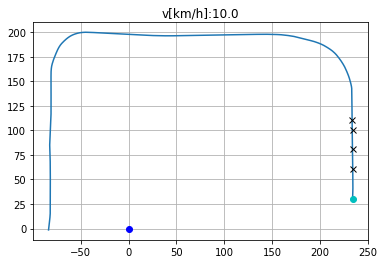

real_dist:  318.44635009765625
vehicle.get_transform() Transform(Location(x=233.786560, y=25.528683, z=-0.005484), Rotation(pitch=0.072195, yaw=87.779732, roll=-0.077057))
vehicleToFollow.get_transform() Transform(Location(x=-83.511276, y=-1.492601, z=-0.011247), Rotation(pitch=-0.141692, yaw=-96.758911, roll=0.083469))


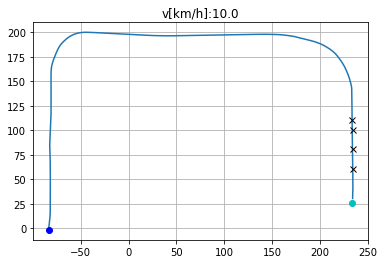

real_dist:  4.9974822998046875
vehicle.get_transform() Transform(Location(x=233.786636, y=25.529177, z=-0.014259), Rotation(pitch=0.143352, yaw=87.779716, roll=-0.055176))
vehicleToFollow.get_transform() Transform(Location(x=233.980576, y=30.522856, z=0.005383), Rotation(pitch=0.029424, yaw=87.779808, roll=-0.010712))


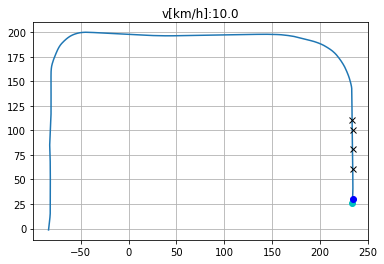

real_dist:  5.017130374908447
vehicle.get_transform() Transform(Location(x=233.786667, y=25.529619, z=-0.020672), Rotation(pitch=0.206477, yaw=87.779739, roll=-0.015015))
vehicleToFollow.get_transform() Transform(Location(x=233.981369, y=30.542904, z=0.005097), Rotation(pitch=0.029028, yaw=87.779747, roll=-0.010010))


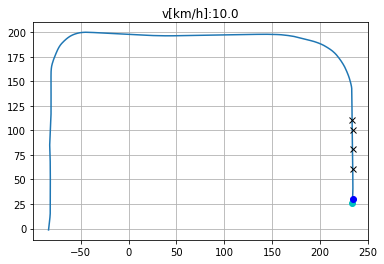

real_dist:  5.036465167999268
vehicle.get_transform() Transform(Location(x=233.786728, y=25.529972, z=-0.025086), Rotation(pitch=0.256316, yaw=87.779839, roll=0.017971))
vehicleToFollow.get_transform() Transform(Location(x=233.982101, y=30.562557, z=0.004822), Rotation(pitch=0.028502, yaw=87.779663, roll=-0.009338))


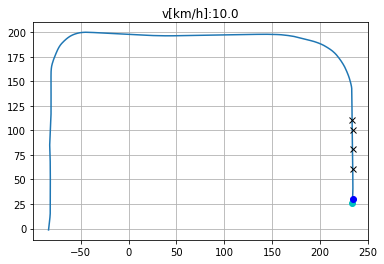

real_dist:  5.055478096008301
vehicle.get_transform() Transform(Location(x=233.786774, y=25.530216, z=-0.027869), Rotation(pitch=0.291109, yaw=87.779907, roll=0.038884))
vehicleToFollow.get_transform() Transform(Location(x=233.982834, y=30.581787, z=0.004558), Rotation(pitch=0.027819, yaw=87.779617, roll=-0.008698))


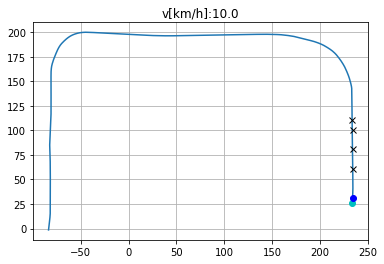

real_dist:  5.074142932891846
vehicle.get_transform() Transform(Location(x=233.786804, y=25.530361, z=-0.029380), Rotation(pitch=0.311607, yaw=87.779930, roll=0.048137))
vehicleToFollow.get_transform() Transform(Location(x=233.983551, y=30.600576, z=0.004305), Rotation(pitch=0.026993, yaw=87.779518, roll=-0.008087))


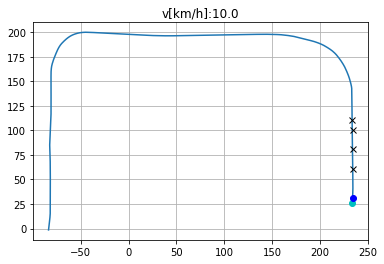

real_dist:  5.092440605163574
vehicle.get_transform() Transform(Location(x=233.786804, y=25.530416, z=-0.029945), Rotation(pitch=0.319974, yaw=87.779930, roll=0.048324))
vehicleToFollow.get_transform() Transform(Location(x=233.984268, y=30.618914, z=0.004062), Rotation(pitch=0.026044, yaw=87.779449, roll=-0.007538))


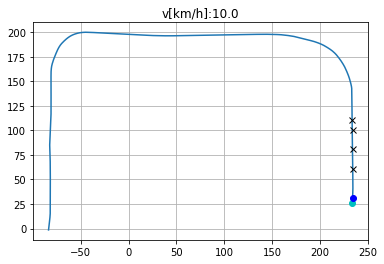

real_dist:  5.110342979431152
vehicle.get_transform() Transform(Location(x=233.786789, y=25.530413, z=-0.029847), Rotation(pitch=0.319072, yaw=87.779884, roll=0.042589))
vehicleToFollow.get_transform() Transform(Location(x=233.984955, y=30.636801, z=0.003829), Rotation(pitch=0.024917, yaw=87.779373, roll=-0.006958))


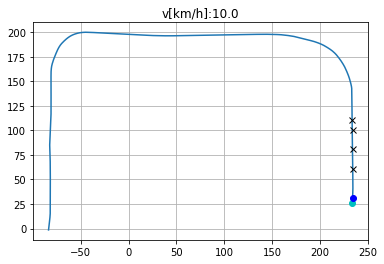

real_dist:  5.127838611602783
vehicle.get_transform() Transform(Location(x=233.786758, y=25.530363, z=-0.029321), Rotation(pitch=0.311825, yaw=87.779854, roll=0.034181))
vehicleToFollow.get_transform() Transform(Location(x=233.985641, y=30.654238, z=0.003606), Rotation(pitch=0.023680, yaw=87.779297, roll=-0.006439))


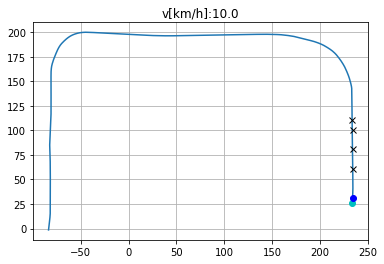

real_dist:  5.144903182983398
vehicle.get_transform() Transform(Location(x=233.786713, y=25.530293, z=-0.028553), Rotation(pitch=0.300856, yaw=87.779800, roll=0.024707))
vehicleToFollow.get_transform() Transform(Location(x=233.986282, y=30.671225, z=0.003392), Rotation(pitch=0.022321, yaw=87.779221, roll=-0.005920))


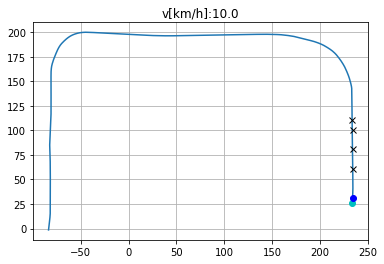

real_dist:  5.161538124084473
vehicle.get_transform() Transform(Location(x=233.786667, y=25.530205, z=-0.027682), Rotation(pitch=0.288330, yaw=87.779739, roll=0.015116))
vehicleToFollow.get_transform() Transform(Location(x=233.986954, y=30.687763, z=0.003186), Rotation(pitch=0.020887, yaw=87.779144, roll=-0.005463))


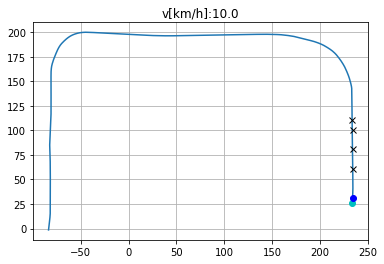

real_dist:  5.177736282348633
vehicle.get_transform() Transform(Location(x=233.786636, y=25.530117, z=-0.026808), Rotation(pitch=0.275864, yaw=87.779663, roll=0.006509))
vehicleToFollow.get_transform() Transform(Location(x=233.987579, y=30.703867, z=0.002989), Rotation(pitch=0.019391, yaw=87.779060, roll=-0.005005))


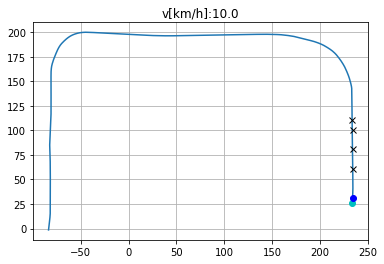

real_dist:  5.193495273590088
vehicle.get_transform() Transform(Location(x=233.786621, y=25.530043, z=-0.025997), Rotation(pitch=0.264547, yaw=87.779625, roll=-0.000519))
vehicleToFollow.get_transform() Transform(Location(x=233.988174, y=30.719545, z=0.002800), Rotation(pitch=0.017834, yaw=87.778961, roll=-0.004547))


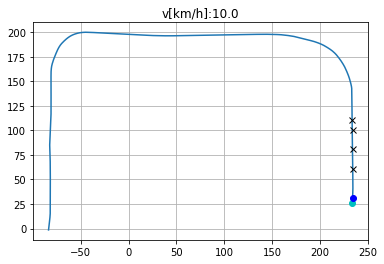

real_dist:  5.2088212966918945
vehicle.get_transform() Transform(Location(x=233.786591, y=25.529978, z=-0.025288), Rotation(pitch=0.255026, yaw=87.779602, roll=-0.005737))
vehicleToFollow.get_transform() Transform(Location(x=233.988785, y=30.734798, z=0.002618), Rotation(pitch=0.016242, yaw=87.778938, roll=-0.004150))


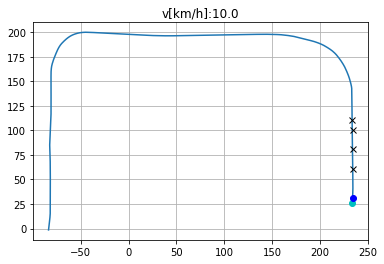

real_dist:  5.223715782165527
vehicle.get_transform() Transform(Location(x=233.786575, y=25.529928, z=-0.024698), Rotation(pitch=0.247574, yaw=87.779572, roll=-0.009216))
vehicleToFollow.get_transform() Transform(Location(x=233.989365, y=30.749636, z=0.002443), Rotation(pitch=0.014644, yaw=87.778824, roll=-0.003754))


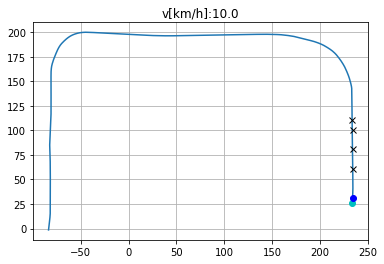

real_dist:  5.23820161819458
vehicle.get_transform() Transform(Location(x=233.786575, y=25.529890, z=-0.024230), Rotation(pitch=0.242185, yaw=87.779541, roll=-0.011108))
vehicleToFollow.get_transform() Transform(Location(x=233.989914, y=30.764076, z=0.002276), Rotation(pitch=0.013025, yaw=87.778770, roll=-0.003357))


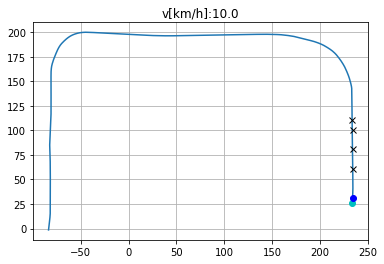

real_dist:  5.250733375549316
vehicle.get_transform() Transform(Location(x=233.786560, y=25.529867, z=-0.023876), Rotation(pitch=0.238708, yaw=87.779549, roll=-0.011749))
vehicleToFollow.get_transform() Transform(Location(x=233.990326, y=30.776581, z=0.002112), Rotation(pitch=0.011905, yaw=87.770538, roll=-0.003021))


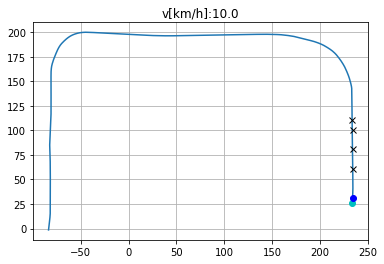

real_dist:  5.260929107666016
vehicle.get_transform() Transform(Location(x=233.786575, y=25.529854, z=-0.023624), Rotation(pitch=0.236823, yaw=87.779541, roll=-0.011414))
vehicleToFollow.get_transform() Transform(Location(x=233.990768, y=30.786757, z=0.001953), Rotation(pitch=0.011058, yaw=87.771988, roll=-0.002655))


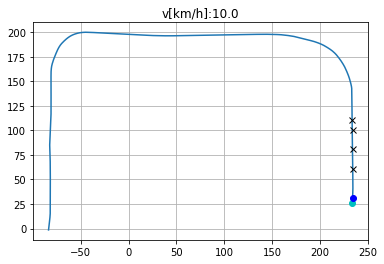

real_dist:  5.270101070404053
vehicle.get_transform() Transform(Location(x=233.786575, y=25.529850, z=-0.023456), Rotation(pitch=0.236222, yaw=87.779541, roll=-0.010406))
vehicleToFollow.get_transform() Transform(Location(x=233.991180, y=30.795918, z=0.001801), Rotation(pitch=0.009958, yaw=87.784439, roll=-0.002380))


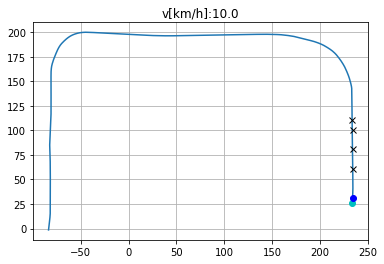

real_dist:  5.277819633483887
vehicle.get_transform() Transform(Location(x=233.786575, y=25.529850, z=-0.023356), Rotation(pitch=0.236557, yaw=87.779541, roll=-0.009003))
vehicleToFollow.get_transform() Transform(Location(x=233.991440, y=30.803633, z=0.001656), Rotation(pitch=0.008797, yaw=87.786125, roll=-0.002045))


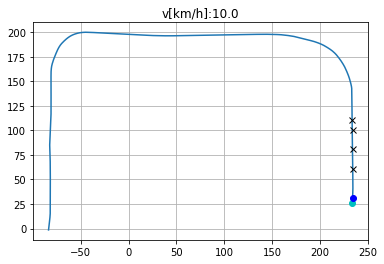

real_dist:  5.284393310546875
vehicle.get_transform() Transform(Location(x=233.786575, y=25.529856, z=-0.023308), Rotation(pitch=0.237513, yaw=87.779564, roll=-0.007416))
vehicleToFollow.get_transform() Transform(Location(x=233.991714, y=30.810207, z=0.001517), Rotation(pitch=0.007452, yaw=87.784592, roll=-0.001740))


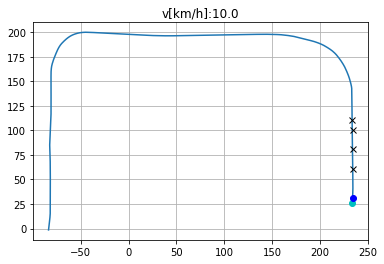

real_dist:  5.290926456451416
vehicle.get_transform() Transform(Location(x=233.786591, y=25.529858, z=-0.023299), Rotation(pitch=0.238223, yaw=87.779541, roll=-0.006470))
vehicleToFollow.get_transform() Transform(Location(x=233.991989, y=30.816738, z=0.001386), Rotation(pitch=0.005655, yaw=87.789986, roll=-0.001465))


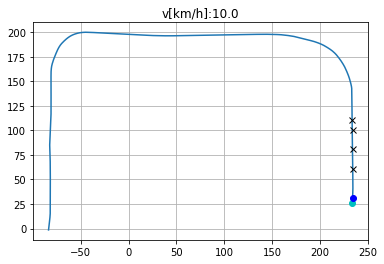

real_dist:  5.299298286437988
vehicle.get_transform() Transform(Location(x=233.786591, y=25.529860, z=-0.023316), Rotation(pitch=0.238940, yaw=87.779541, roll=-0.005524))
vehicleToFollow.get_transform() Transform(Location(x=233.992615, y=30.825094, z=0.001265), Rotation(pitch=0.003115, yaw=87.848000, roll=-0.001221))


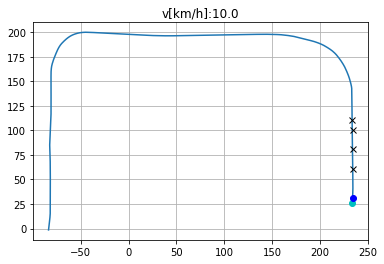

real_dist:  5.310590744018555
vehicle.get_transform() Transform(Location(x=233.786591, y=25.529865, z=-0.023346), Rotation(pitch=0.240074, yaw=87.779541, roll=-0.004303))
vehicleToFollow.get_transform() Transform(Location(x=233.993317, y=30.836374, z=0.001151), Rotation(pitch=0.000041, yaw=87.914429, roll=-0.000946))


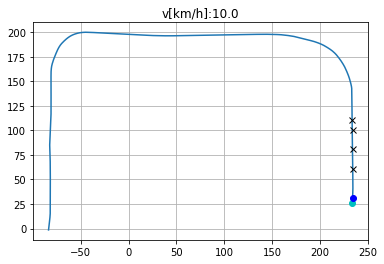

real_dist:  5.3254194259643555
vehicle.get_transform() Transform(Location(x=233.786591, y=25.529871, z=-0.023382), Rotation(pitch=0.241358, yaw=87.779572, roll=-0.003052))
vehicleToFollow.get_transform() Transform(Location(x=233.994186, y=30.851187, z=0.001044), Rotation(pitch=-0.003354, yaw=87.978477, roll=-0.000702))


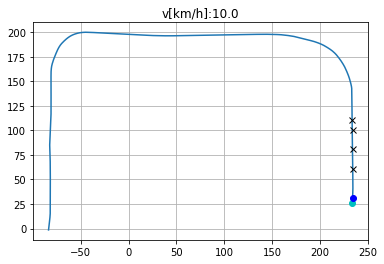

real_dist:  5.3447113037109375
vehicle.get_transform() Transform(Location(x=233.786591, y=25.529875, z=-0.023419), Rotation(pitch=0.242663, yaw=87.779556, roll=-0.001953))
vehicleToFollow.get_transform() Transform(Location(x=233.995132, y=30.870461, z=0.000943), Rotation(pitch=-0.007049, yaw=88.029213, roll=-0.000458))


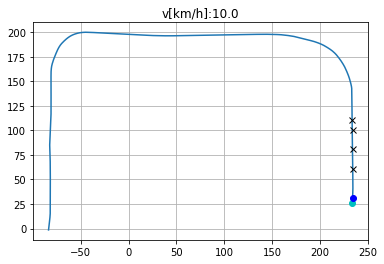

real_dist:  5.37091588973999
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529877, z=-0.023454), Rotation(pitch=0.243838, yaw=87.779572, roll=-0.001038))
vehicleToFollow.get_transform() Transform(Location(x=233.996017, y=30.896654, z=0.000848), Rotation(pitch=-0.011174, yaw=88.034782, roll=-0.000183))


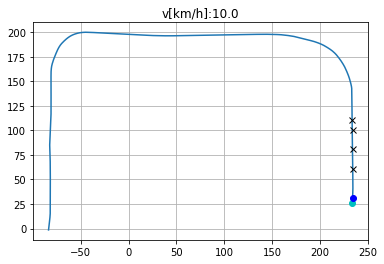

real_dist:  5.404406547546387
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529882, z=-0.023485), Rotation(pitch=0.244835, yaw=87.779572, roll=-0.000336))
vehicleToFollow.get_transform() Transform(Location(x=233.997070, y=30.930136, z=0.000758), Rotation(pitch=-0.015259, yaw=88.017830, roll=0.000044))


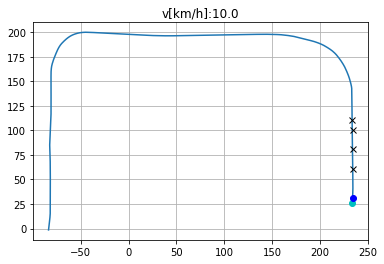

real_dist:  5.445226669311523
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529884, z=-0.023511), Rotation(pitch=0.245641, yaw=87.779556, roll=0.000190))
vehicleToFollow.get_transform() Transform(Location(x=233.998489, y=30.970934, z=0.000669), Rotation(pitch=-0.018804, yaw=88.018509, roll=0.000244))


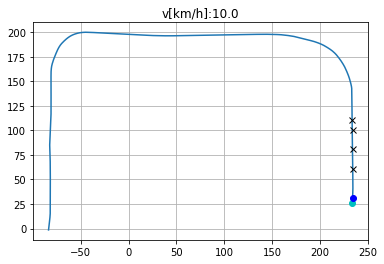

real_dist:  5.491967678070068
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529886, z=-0.023531), Rotation(pitch=0.246242, yaw=87.779572, roll=0.000543))
vehicleToFollow.get_transform() Transform(Location(x=234.000092, y=31.017651, z=0.000578), Rotation(pitch=-0.021303, yaw=88.020554, roll=0.000445))


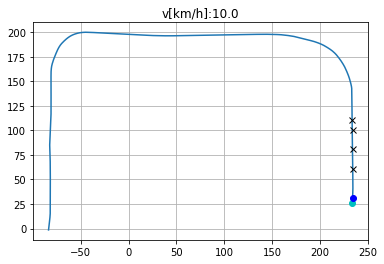

real_dist:  5.5454206466674805
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023546), Rotation(pitch=0.246672, yaw=87.779572, roll=0.000761))
vehicleToFollow.get_transform() Transform(Location(x=234.002029, y=31.071074, z=0.000487), Rotation(pitch=-0.023045, yaw=88.022034, roll=0.000799))


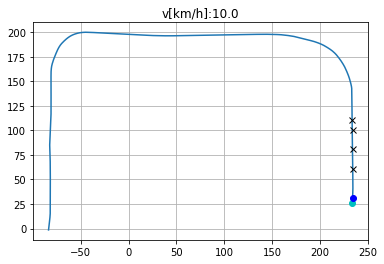

real_dist:  5.605675220489502
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023557), Rotation(pitch=0.246945, yaw=87.779572, roll=0.000877))
vehicleToFollow.get_transform() Transform(Location(x=234.004135, y=31.131292, z=0.000395), Rotation(pitch=-0.024015, yaw=88.024246, roll=0.000974))


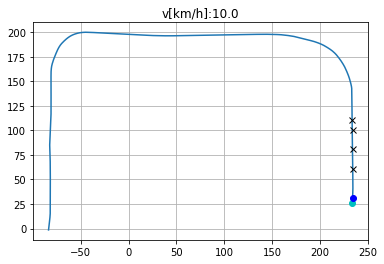

real_dist:  5.672224044799805
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529892, z=-0.023563), Rotation(pitch=0.247103, yaw=87.779572, roll=0.000921))
vehicleToFollow.get_transform() Transform(Location(x=234.006424, y=31.197805, z=0.000302), Rotation(pitch=-0.024104, yaw=88.026459, roll=0.001136))


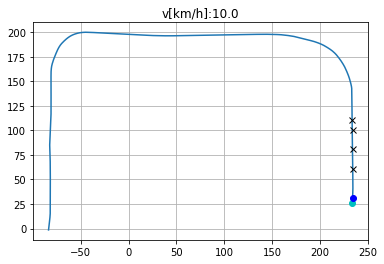

real_dist:  5.744745254516602
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529892, z=-0.023567), Rotation(pitch=0.247103, yaw=87.779572, roll=0.000921))
vehicleToFollow.get_transform() Transform(Location(x=234.008942, y=31.270285, z=0.000208), Rotation(pitch=-0.023339, yaw=88.028702, roll=0.001288))


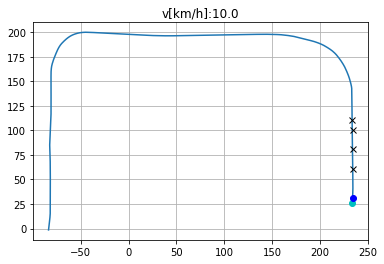

real_dist:  5.822990417480469
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529892, z=-0.023567), Rotation(pitch=0.247103, yaw=87.779572, roll=0.000921))
vehicleToFollow.get_transform() Transform(Location(x=234.011658, y=31.348484, z=0.000113), Rotation(pitch=-0.021843, yaw=88.030937, roll=0.001430))


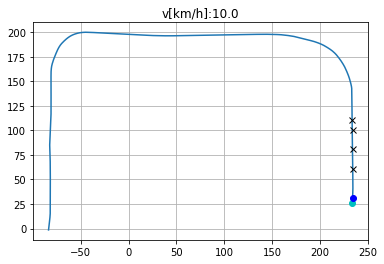

real_dist:  5.9067840576171875
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529892, z=-0.023565), Rotation(pitch=0.247103, yaw=87.779572, roll=0.000921))
vehicleToFollow.get_transform() Transform(Location(x=234.014542, y=31.432230, z=0.000019), Rotation(pitch=-0.019739, yaw=88.033180, roll=0.001553))


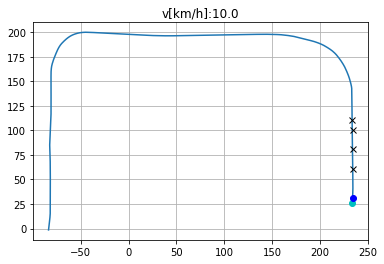

real_dist:  5.996012210845947
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529892, z=-0.023563), Rotation(pitch=0.247021, yaw=87.779572, roll=0.000779))
vehicleToFollow.get_transform() Transform(Location(x=234.017624, y=31.521406, z=-0.000076), Rotation(pitch=-0.017185, yaw=88.035545, roll=0.001666))


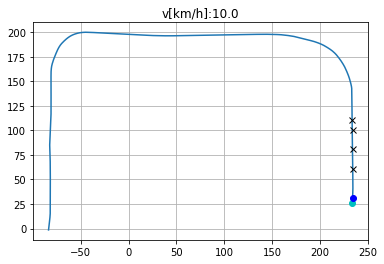

real_dist:  6.090569019317627
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023561), Rotation(pitch=0.247021, yaw=87.779572, roll=0.000779))
vehicleToFollow.get_transform() Transform(Location(x=234.020874, y=31.615908, z=-0.000169), Rotation(pitch=-0.014282, yaw=88.037865, roll=0.001775))


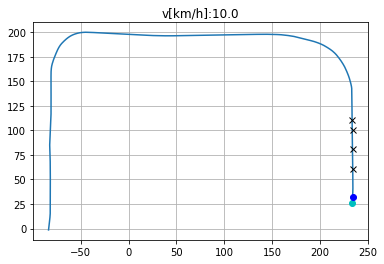

real_dist:  6.190404415130615
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023559), Rotation(pitch=0.246864, yaw=87.779572, roll=0.000670))
vehicleToFollow.get_transform() Transform(Location(x=234.024338, y=31.715685, z=-0.000260), Rotation(pitch=-0.011140, yaw=88.040375, roll=0.001875))


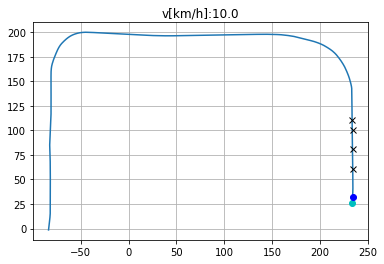

real_dist:  6.295470714569092
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023558), Rotation(pitch=0.246864, yaw=87.779572, roll=0.000670))
vehicleToFollow.get_transform() Transform(Location(x=234.027924, y=31.820692, z=-0.000349), Rotation(pitch=-0.007903, yaw=88.042854, roll=0.001959))


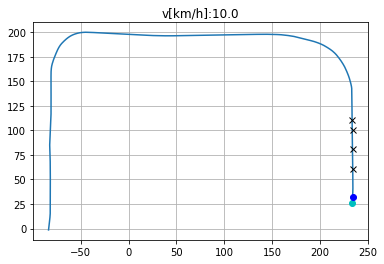

real_dist:  6.405726432800293
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023556), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.031738, y=31.930883, z=-0.000436), Rotation(pitch=-0.004576, yaw=88.045433, roll=0.002050))


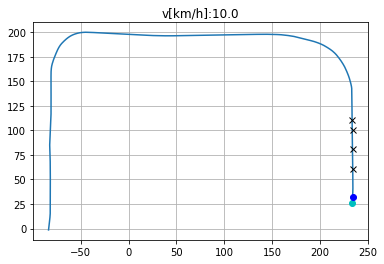

real_dist:  6.521157264709473
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023555), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.035660, y=32.046249, z=-0.000520), Rotation(pitch=-0.001311, yaw=88.048172, roll=0.002124))


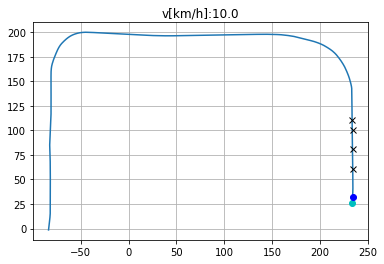

real_dist:  6.641716480255127
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023555), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.039780, y=32.166740, z=-0.000602), Rotation(pitch=0.001974, yaw=88.050911, roll=0.002207))


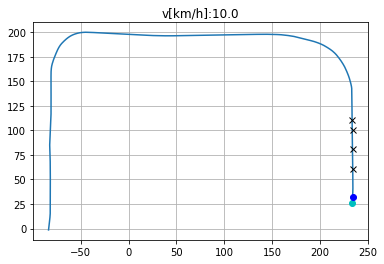

real_dist:  6.767383575439453
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.044083, y=32.292336, z=-0.000680), Rotation(pitch=0.005136, yaw=88.053711, roll=0.002273))


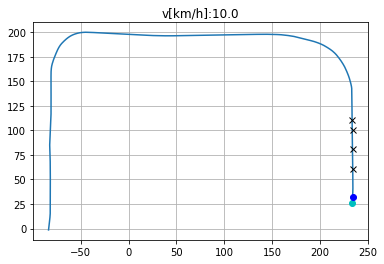

real_dist:  6.898130416870117
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.048553, y=32.423008, z=-0.000756), Rotation(pitch=0.008203, yaw=88.056648, roll=0.002336))


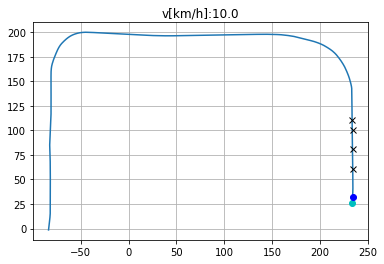

real_dist:  7.0339226722717285
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.053177, y=32.558723, z=-0.000829), Rotation(pitch=0.011154, yaw=88.059586, roll=0.002395))


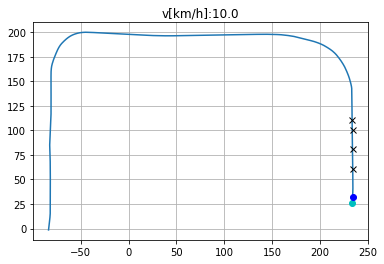

real_dist:  7.17473030090332
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.057968, y=32.699451, z=-0.000899), Rotation(pitch=0.013995, yaw=88.062645, roll=0.002462))


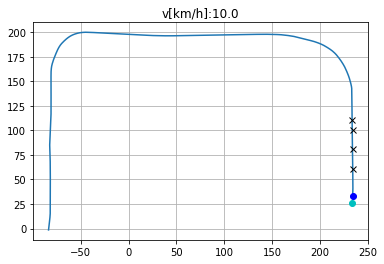

real_dist:  7.320529937744141
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.062927, y=32.845169, z=-0.000966), Rotation(pitch=0.016686, yaw=88.065781, roll=0.002514))


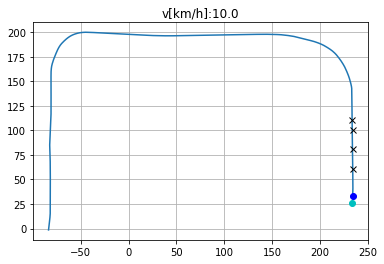

real_dist:  7.47129487991333
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.068024, y=32.995850, z=-0.001031), Rotation(pitch=0.019254, yaw=88.068977, roll=0.002564))


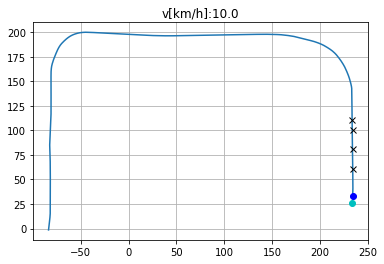

real_dist:  7.6269941329956055
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.073273, y=33.151463, z=-0.001093), Rotation(pitch=0.021686, yaw=88.072235, roll=0.002611))


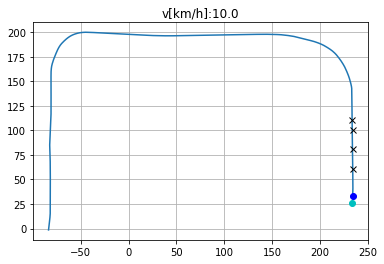

real_dist:  7.787592887878418
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.078644, y=33.311974, z=-0.001152), Rotation(pitch=0.024001, yaw=88.075562, roll=0.002667))


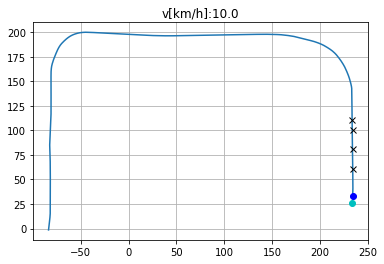

real_dist:  7.95308256149292
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.084229, y=33.477371, z=-0.001209), Rotation(pitch=0.026160, yaw=88.078949, roll=0.002708))


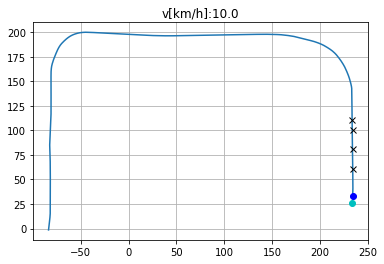

real_dist:  8.123442649841309
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.089951, y=33.647636, z=-0.001041), Rotation(pitch=0.028236, yaw=88.082291, roll=0.002748))


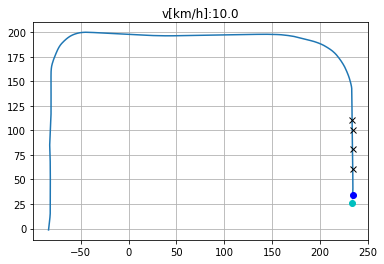

real_dist:  8.298629760742188
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.095795, y=33.822727, z=-0.000986), Rotation(pitch=0.030183, yaw=88.085846, roll=0.002795))


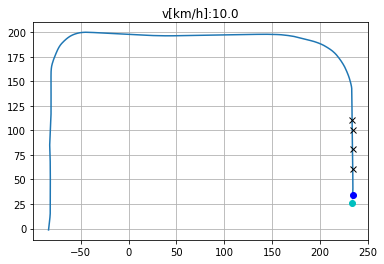

real_dist:  8.478623390197754
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.101852, y=34.002621, z=-0.001001), Rotation(pitch=0.031993, yaw=88.089378, roll=0.002829))


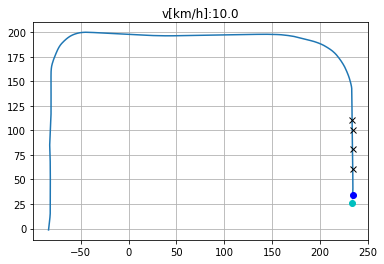

real_dist:  8.663394927978516
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.108063, y=34.187290, z=-0.001059), Rotation(pitch=0.033693, yaw=88.092972, roll=0.002862))


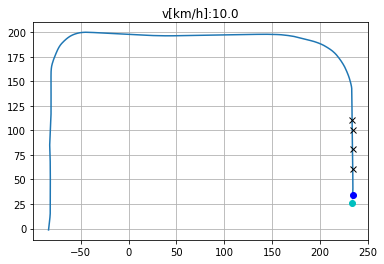

real_dist:  8.852913856506348
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.114410, y=34.376705, z=-0.001140), Rotation(pitch=0.035298, yaw=88.096672, roll=0.002893))


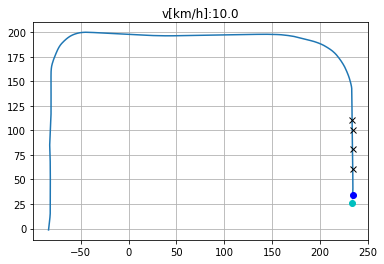

real_dist:  9.047161102294922
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.120895, y=34.570847, z=-0.001234), Rotation(pitch=0.036781, yaw=88.100365, roll=0.002923))


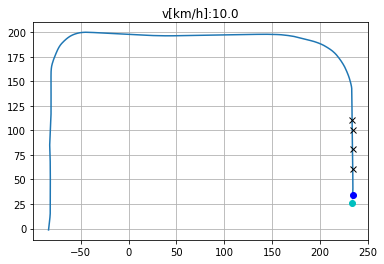

real_dist:  9.246110916137695
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.127518, y=34.769688, z=-0.001332), Rotation(pitch=0.038181, yaw=88.104126, roll=0.002960))


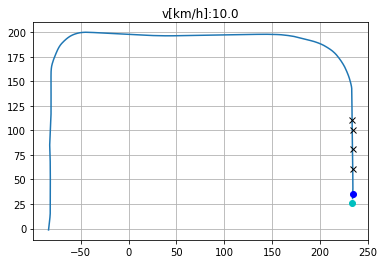

real_dist:  9.449739456176758
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.134293, y=34.973206, z=-0.001430), Rotation(pitch=0.039478, yaw=88.107964, roll=0.002986))


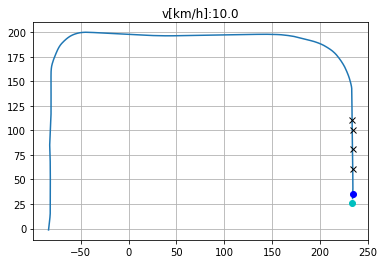

real_dist:  9.658003807067871
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.141190, y=35.181358, z=-0.001524), Rotation(pitch=0.040708, yaw=88.111862, roll=0.003009))


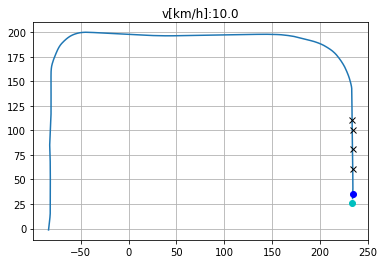

real_dist:  9.870887756347656
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.148239, y=35.394127, z=-0.001613), Rotation(pitch=0.041842, yaw=88.115791, roll=0.003043))


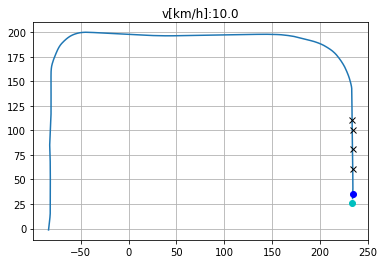

real_dist:  10.08836841583252
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.155380, y=35.611492, z=-0.001696), Rotation(pitch=0.042914, yaw=88.119766, roll=0.003062))


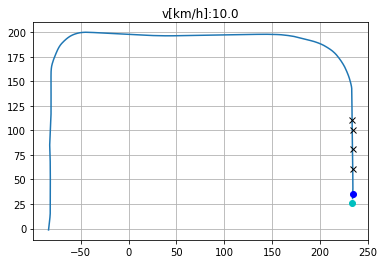

real_dist:  10.310418128967285
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.162704, y=35.833424, z=-0.001773), Rotation(pitch=0.043904, yaw=88.123810, roll=0.003081))


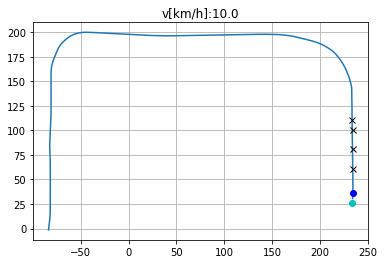

real_dist:  10.537025451660156
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.170166, y=36.059910, z=-0.001844), Rotation(pitch=0.044820, yaw=88.127922, roll=0.003111))


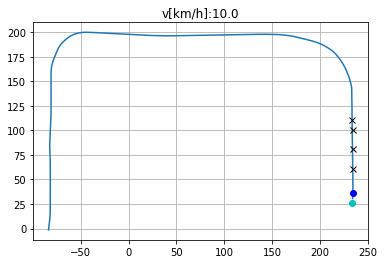

real_dist:  10.763513565063477
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.177612, y=36.286278, z=-0.001918), Rotation(pitch=0.047176, yaw=88.130066, roll=0.003113))


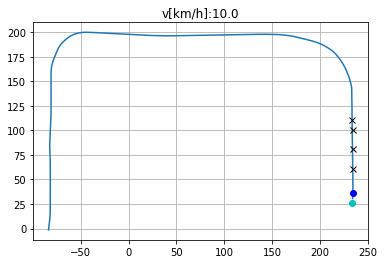

real_dist:  10.989873886108398
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.184998, y=36.512520, z=-0.001989), Rotation(pitch=0.050079, yaw=88.131180, roll=0.003116))


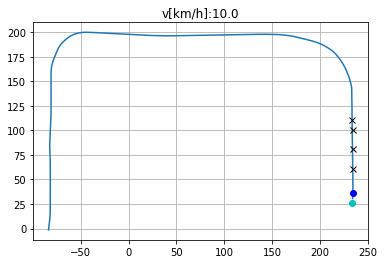

real_dist:  11.216120719909668
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.192383, y=36.738647, z=-0.002056), Rotation(pitch=0.052920, yaw=88.131737, roll=0.003098))


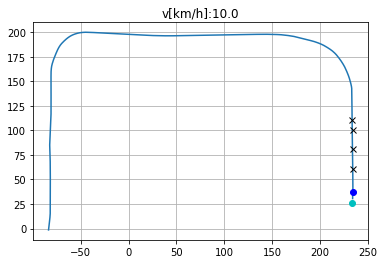

real_dist:  11.442252159118652
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.199783, y=36.964661, z=-0.002116), Rotation(pitch=0.055434, yaw=88.131966, roll=0.003095))


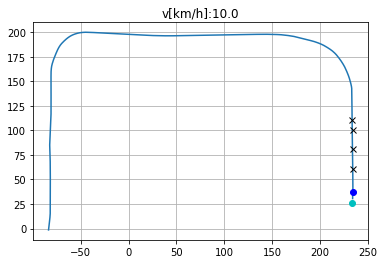

real_dist:  11.6682767868042
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.207138, y=37.190567, z=-0.002170), Rotation(pitch=0.057401, yaw=88.132088, roll=0.003085))


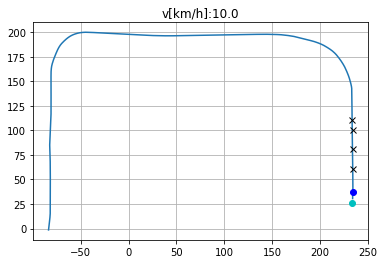

real_dist:  11.894176483154297
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.214523, y=37.416348, z=-0.002217), Rotation(pitch=0.058781, yaw=88.132156, roll=0.003090))


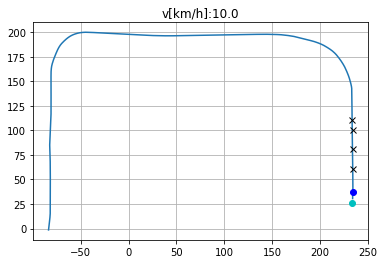

real_dist:  12.119965553283691
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.221909, y=37.642017, z=-0.002259), Rotation(pitch=0.059539, yaw=88.132217, roll=0.003086))


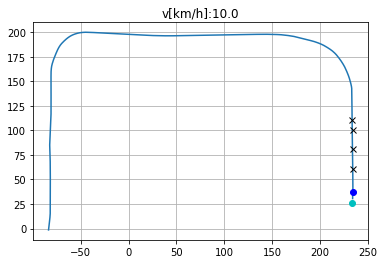

real_dist:  12.34564208984375
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.229248, y=37.867577, z=-0.002294), Rotation(pitch=0.059730, yaw=88.132217, roll=0.003097))


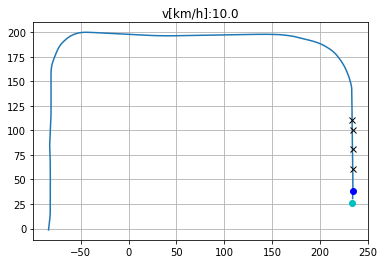

real_dist:  12.571205139160156
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529890, z=-0.023553), Rotation(pitch=0.246741, yaw=87.779572, roll=0.000599))
vehicleToFollow.get_transform() Transform(Location(x=234.236572, y=38.093021, z=-0.002324), Rotation(pitch=0.059388, yaw=88.132217, roll=0.003110))


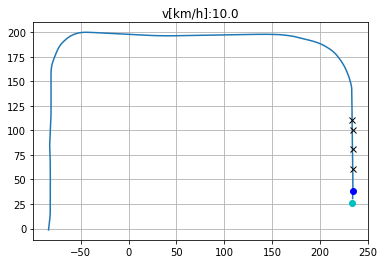

real_dist:  13.247237205505371
vehicle.get_transform() Transform(Location(x=233.786621, y=25.529898, z=-0.023553), Rotation(pitch=0.246631, yaw=87.779541, roll=0.000571))
vehicleToFollow.get_transform() Transform(Location(x=234.258621, y=38.768707, z=-0.002370), Rotation(pitch=0.061424, yaw=88.132164, roll=0.003104))


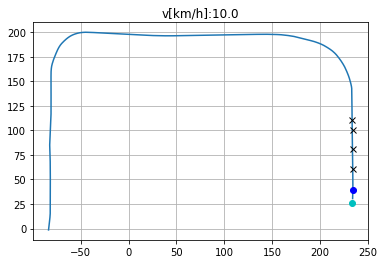

real_dist:  13.015008926391602
vehicle.get_transform() Transform(Location(x=233.786942, y=25.536861, z=-0.023247), Rotation(pitch=0.213095, yaw=87.776810, roll=-0.002960))
vehicleToFollow.get_transform() Transform(Location(x=234.251282, y=38.543568, z=-0.002368), Rotation(pitch=0.056991, yaw=88.132195, roll=0.003157))


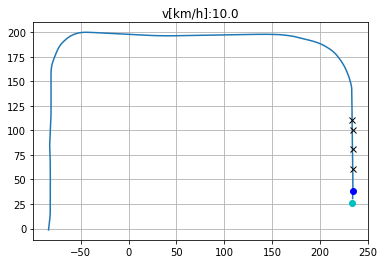

real_dist:  13.222972869873047
vehicle.get_transform() Transform(Location(x=233.787766, y=25.554098, z=-0.022640), Rotation(pitch=0.149404, yaw=87.769402, roll=-0.012268))
vehicleToFollow.get_transform() Transform(Location(x=234.258621, y=38.768669, z=-0.002386), Rotation(pitch=0.055516, yaw=88.132164, roll=0.003184))


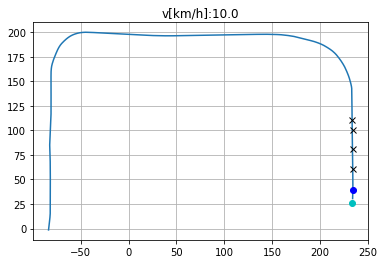

real_dist:  13.422003746032715
vehicle.get_transform() Transform(Location(x=233.789032, y=25.580151, z=-0.021948), Rotation(pitch=0.080159, yaw=87.759521, roll=-0.022461))
vehicleToFollow.get_transform() Transform(Location(x=234.265976, y=38.993664, z=-0.002401), Rotation(pitch=0.053781, yaw=88.132164, roll=0.003212))


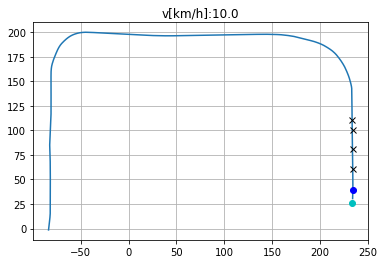

real_dist:  13.61386489868164
vehicle.get_transform() Transform(Location(x=233.790665, y=25.613255, z=-0.021332), Rotation(pitch=0.021044, yaw=87.747665, roll=-0.030701))
vehicleToFollow.get_transform() Transform(Location(x=234.273315, y=39.218548, z=-0.002414), Rotation(pitch=0.051848, yaw=88.132164, roll=0.003240))


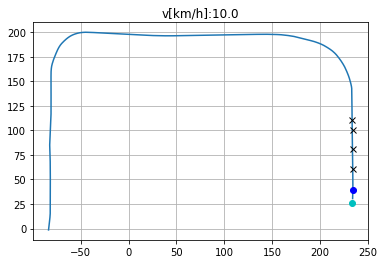

real_dist:  13.79962158203125
vehicle.get_transform() Transform(Location(x=233.792511, y=25.652348, z=-0.020864), Rotation(pitch=-0.022307, yaw=87.735229, roll=-0.034882))
vehicleToFollow.get_transform() Transform(Location(x=234.280655, y=39.443321, z=-0.002425), Rotation(pitch=0.049765, yaw=88.132164, roll=0.003266))


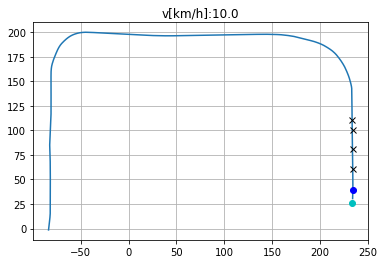

real_dist:  13.986242294311523
vehicle.get_transform() Transform(Location(x=233.794586, y=25.696991, z=-0.020556), Rotation(pitch=-0.050687, yaw=87.723167, roll=-0.035004))
vehicleToFollow.get_transform() Transform(Location(x=234.285950, y=39.674587, z=-0.002421), Rotation(pitch=0.045434, yaw=88.246780, roll=0.007599))


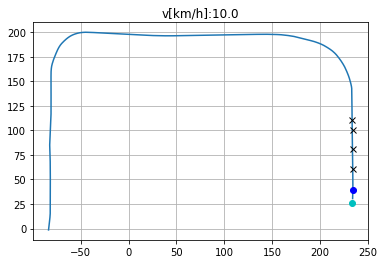

real_dist:  14.17363166809082
vehicle.get_transform() Transform(Location(x=233.796875, y=25.747074, z=-0.020385), Rotation(pitch=-0.067168, yaw=87.712166, roll=-0.031952))
vehicleToFollow.get_transform() Transform(Location(x=234.287048, y=39.912216, z=-0.002411), Rotation(pitch=0.040298, yaw=88.574883, roll=0.012868))


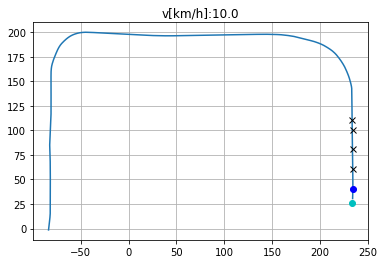

real_dist:  14.36114501953125
vehicle.get_transform() Transform(Location(x=233.799347, y=25.802572, z=-0.020323), Rotation(pitch=-0.074989, yaw=87.702797, roll=-0.026855))
vehicleToFollow.get_transform() Transform(Location(x=234.282990, y=40.155560, z=-0.002402), Rotation(pitch=0.035298, yaw=89.141586, roll=0.018286))


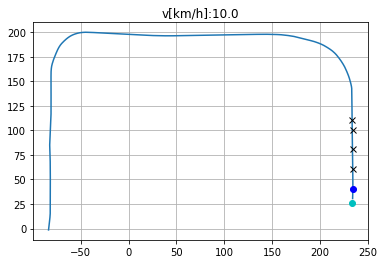

real_dist:  14.549257278442383
vehicle.get_transform() Transform(Location(x=233.801971, y=25.863487, z=-0.020339), Rotation(pitch=-0.076935, yaw=87.695671, roll=-0.020630))
vehicleToFollow.get_transform() Transform(Location(x=234.278763, y=40.404919, z=-0.002397), Rotation(pitch=0.030688, yaw=89.662537, roll=0.011091))


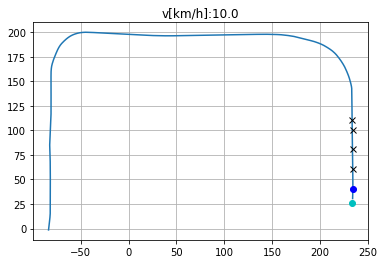

real_dist:  14.737947463989258
vehicle.get_transform() Transform(Location(x=233.805069, y=25.929804, z=-0.020403), Rotation(pitch=-0.075344, yaw=87.677124, roll=-0.023132))
vehicleToFollow.get_transform() Transform(Location(x=234.277359, y=40.660172, z=-0.002395), Rotation(pitch=0.026665, yaw=89.962463, roll=0.004140))


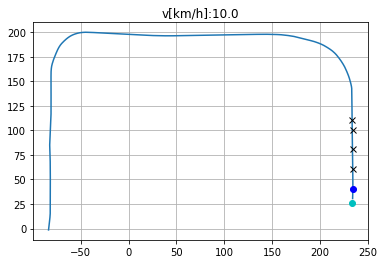

real_dist:  14.927021026611328
vehicle.get_transform() Transform(Location(x=233.808594, y=26.001545, z=-0.020490), Rotation(pitch=-0.071929, yaw=87.654282, roll=-0.023346))
vehicleToFollow.get_transform() Transform(Location(x=234.276886, y=40.921207, z=-0.002395), Rotation(pitch=0.023400, yaw=90.134979, roll=0.001146))


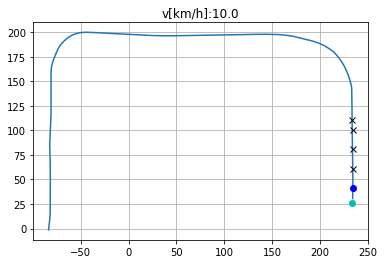

real_dist:  15.116244316101074
len(fplist):  600
vehicle.get_transform() Transform(Location(x=233.812393, y=26.078732, z=-0.020588), Rotation(pitch=-0.067721, yaw=87.629204, roll=-0.021698))
vehicleToFollow.get_transform() Transform(Location(x=234.276459, y=41.187840, z=-0.002398), Rotation(pitch=0.020948, yaw=90.236038, roll=-0.000092))
trail_path.x[1:]:  [232.00358529301343, 232.0339959739587, 232.0832139565517, 232.1545234388217, 232.24764369131276, 232.35953413766418, 232.48520991736098, 232.61827388314893, 232.7514646527765, 232.87762141948832, 232.99035383689284, 233.08447378364716, 233.1570057453415, 233.20771905631685, 233.24169044401117]
trail_path.y[1:]:  [31.08903682949656, 31.56490079123446, 32.04346514361459, 32.527295330440815, 33.01516263723313, 33.50941363563496, 34.00999939400187, 34.51732365557137, 35.03230745138345, 35.55471980752895, 36.085221770384535, 36.62224547406499, 37.16577101036158, 37.71569648631192, 38.33454486114123]
trail_s0:  0.47621058421967866
i:  87


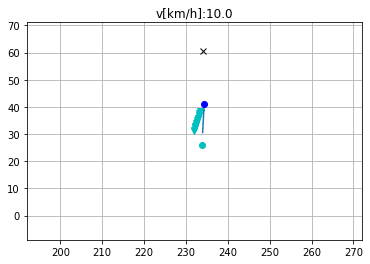

real_dist:  15.305411338806152
len(fplist):  600
vehicle.get_transform() Transform(Location(x=233.816513, y=26.161390, z=-0.020684), Rotation(pitch=-0.063473, yaw=87.603203, roll=-0.018768))
vehicleToFollow.get_transform() Transform(Location(x=234.275742, y=41.459900, z=-0.002404), Rotation(pitch=0.019268, yaw=90.296890, roll=-0.000671))
trail_path.x[1:]:  [232.0350565376888, 232.08524653232453, 232.1574698436179, 232.2513809774162, 232.36396313973285, 232.49026411616794, 232.62379814868027, 232.7573764637799, 232.88383271707443, 232.99680467225724, 233.09106372710633, 233.16370342655992, 233.21434656724233, 233.2522665561086]
trail_path.y[1:]:  [31.595643132215194, 32.103446845648264, 32.613826127342975, 33.12575789608416, 33.640836623014586, 34.16005453469028, 34.68294815615301, 35.21075709715774, 35.74353396721346, 36.281194336600755, 36.82376656238505, 37.370918761446156, 37.9195105332209, 38.658744101933046]
trail_s0:  0.9852389797421847
i:  88


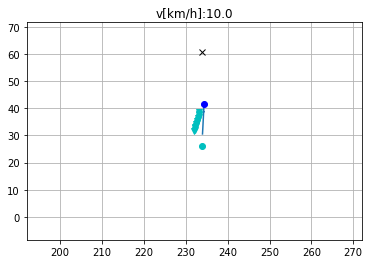

real_dist:  15.494364738464355
len(fplist):  600
vehicle.get_transform() Transform(Location(x=233.820953, y=26.249542, z=-0.020771), Rotation(pitch=-0.059662, yaw=87.575943, roll=-0.016174))
vehicleToFollow.get_transform() Transform(Location(x=234.274689, y=41.737251, z=-0.002414), Rotation(pitch=0.018298, yaw=90.334892, roll=-0.001068))
trail_path.x[1:]:  [232.0868591599071, 232.1637755891845, 232.26858848123854, 232.40125896581625, 232.5593840865269, 232.73837095732233, 232.93218890454455, 233.13378446214134, 233.33564704568602, 233.53010256035216, 233.7098873645854, 233.86876608931686, 234.0017799182268, 234.10592223363147, 234.1799002833295, 234.23120541869693, 234.25711916284692]
trail_path.y[1:]:  [32.134650404604976, 32.668779896345356, 33.192639884973296, 33.703824879418804, 34.19960170673233, 34.67637818380164, 35.13333140391915, 35.56910309518951, 35.98362316162601, 36.37611776206752, 36.74763945426537, 37.0987915618407, 37.43146668973865, 37.74971229783701, 38.04105092920927

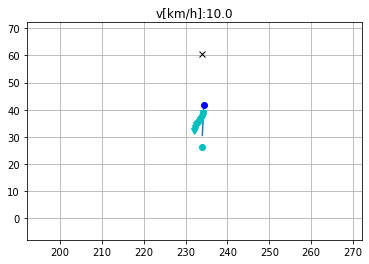

real_dist:  15.682924270629883
len(fplist):  600
vehicle.get_transform() Transform(Location(x=233.825653, y=26.343208, z=-0.020844), Rotation(pitch=-0.056609, yaw=87.547447, roll=-0.014191))
vehicleToFollow.get_transform() Transform(Location(x=234.273376, y=42.019730, z=-0.002426), Rotation(pitch=0.017963, yaw=90.359695, roll=-0.001373))
trail_path.x[1:]:  [232.16551754542007, 232.27442637981488, 232.41470952687646, 232.58398930297, 232.77677322968304, 232.98568860052265, 233.20190352183744, 233.41605760139137, 233.6186020172518, 233.80100766248913, 233.9560364745007, 234.07877724119322, 234.1665855111823, 234.22617251853018, 234.2563261721193]
trail_path.y[1:]:  [32.7062158721358, 33.269223101701904, 33.82015389431623, 34.3535009541255, 34.864740379653576, 35.3516132189991, 35.81231526960264, 36.24569816056795, 36.65168165833377, 37.03104570690686, 37.385520412411005, 37.71840656414049, 38.01887457140773, 38.44704332039071, 38.79038937629352]
trail_s0:  2.100320913157305
i:  90


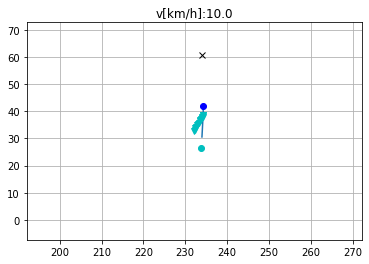

real_dist:  15.870965003967285
len(fplist):  600
destroying actors.
done.


AttributeError: 'NoneType' object has no attribute 'x'

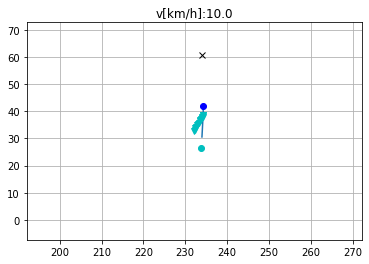

In [22]:
for fileName in drivesFileNames:
     old_tx, old_ty, tx, ty, leading_waypoints, preset_waypoints = main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)
#    main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)


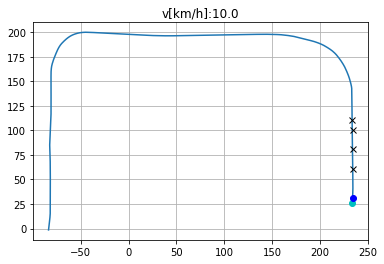

destroying actors.
done.


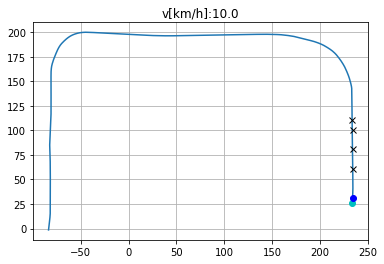

In [29]:
# for fileName in drivesFileNames:
#     old_tx, old_ty, tx, ty, leading_waypoints, preset_waypoints = main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)


In [26]:
len(leading_waypoints)

37

In [25]:
# leading_waypoints

In [25]:
import pandas as pd
import numpy as np
from scipy import signal
df = pd.DataFrame(leading_waypoints)
df

,0,1,2,3,4,5
0,233.981369,30.542904,0.005097,0.029028,87.779747,-0.010010
1,233.982101,30.562557,0.004822,0.028502,87.779663,-0.009338
2,233.982834,30.581787,0.004558,0.027819,87.779617,-0.008698
3,233.983551,30.600576,0.004305,0.026993,87.779518,-0.008087
4,233.984268,30.618914,0.004062,0.026044,87.779449,-0.007538
5,233.984955,30.636801,0.003829,0.024917,87.779373,-0.006958
6,233.985641,30.654238,0.003606,0.023680,87.779297,-0.006439
7,233.986282,30.671225,0.003392,0.022321,87.779221,-0.005920
8,233.986954,30.687763,0.003186,0.020887,87.779144,-0.005463
9,233.987579,30.703867,0.002989,0.019391,87.779060,-0.005005


In [26]:
a = np.array([p[0] for p in leading_waypoints])

a = np.array(leading_waypoints)

In [27]:
a

array([[ 2.33981369e+02,  3.05429039e+01,  5.09685511e-03,
         2.90283021e-02,  8.77797470e+01, -1.00097647e-02],
       [ 2.33982101e+02,  3.05625572e+01,  4.82177734e-03,
         2.85023786e-02,  8.77796631e+01, -9.33837704e-03],
       [ 2.33982834e+02,  3.05817871e+01,  4.55783820e-03,
         2.78193597e-02,  8.77796173e+01, -8.69750883e-03],
       [ 2.33983551e+02,  3.06005764e+01,  4.30469494e-03,
         2.69929059e-02,  8.77795181e+01, -8.08715820e-03],
       [ 2.33984268e+02,  3.06189137e+01,  4.06196574e-03,
         2.60435101e-02,  8.77794495e+01, -7.53784273e-03],
       [ 2.33984955e+02,  3.06368008e+01,  3.82900238e-03,
         2.49165297e-02,  8.77793732e+01, -6.95800874e-03],
       [ 2.33985641e+02,  3.06542377e+01,  3.60572804e-03,
         2.36802641e-02,  8.77792969e+01, -6.43920898e-03],
       [ 2.33986282e+02,  3.06712246e+01,  3.39160906e-03,
         2.23210566e-02,  8.77792206e+01, -5.92041016e-03],
       [ 2.33986954e+02,  3.06877632e+01,  3.186

In [28]:
b = signal.resample(a, len(a) * 100)


In [29]:
len(b)

2700

In [57]:
preset_waypoints[:10]

[[233.9805450439453,
  30.52267837524414,
  0.005986861884593964,
  0.002165169920772314,
  87.77982330322266,
  -0.004791259765625],
 [233.9813232421875,
  30.54275131225586,
  0.005970649421215057,
  0.00514996238052845,
  87.7797622680664,
  -0.004791259299963713],
 [233.98208618164062,
  30.56242561340332,
  0.005954704247415066,
  0.008086943998932838,
  87.77967071533203,
  -0.004791259299963713],
 [233.9828338623047,
  30.581676483154297,
  0.0059394072741270065,
  0.010894151404500008,
  87.77960205078125,
  -0.004821776878088713],
 [233.9835662841797,
  30.60049057006836,
  0.0059252167120575905,
  0.013503283262252808,
  87.7795181274414,
  -0.004821777809411287],
 [233.98426818847656,
  30.61884880065918,
  0.005912093911319971,
  0.01591433957219124,
  87.77944946289062,
  -0.004852294921875],
 [233.98497009277344,
  30.63675880432129,
  0.005900192074477673,
  0.01807950995862484,
  87.77937316894531,
  -0.004852294456213713],
 [233.9856414794922,
  30.65421485900879,
  0.

In [58]:
new_waypoints = leading_waypoints[:9] + preset_waypoints[9:700]

In [59]:
len(new_waypoints)

700

In [34]:
wx = []
wy = []
wz = []

for p in leading_waypoints:
    wp = carla.Transform(carla.Location(p[0] ,p[1],p[2]),carla.Rotation(p[3],p[4],p[5]))
    wx.append(wp.location.x)
    wy.append(wp.location.y)
    wz.append(wp.location.z)


tx, ty, tyaw, tc, trailing_csp = generate_target_course(wx, wy, wz)

In [35]:
tx[:10]

[233.9813690185547,
 233.98519276378192,
 233.98909579878597,
 233.99291294098268,
 233.99743551266573,
 233.9998669866382]

In [36]:
ty[:10]

[30.542903900146484,
 30.642821689743396,
 30.7427563136295,
 30.82947495964892,
 30.940275654742216,
 31.011023887686868]

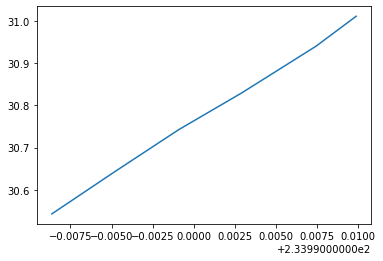

In [37]:
plt.plot(tx, ty)

In [69]:
leading_speed = 5.0 / 3.6 

# TMP obstacle lists
ob = np.array([
               [233.980630, 60.523910],
               [233.980630, 80.523910],
               [233.980630, 100.523910],
               [233.786942, 110.530586],
               ])

trail_c_speed = 5.0 / 3.6  # current speed [m/s]
trail_c_d = 2.0  # current lateral position [m]
trail_c_d_d = 0.0  # current lateral speed [m/s]
trail_c_d_dd = 0.0  # current latral acceleration [m/s]
trail_s0 = 0.0  # current course position    


trail_path =  frenet_optimal_planning(trailing_csp, trail_s0, leading_speed, trail_c_d, trail_c_d_d, trail_c_d_dd, ob)

len(fplist):  900


In [70]:
trail_path

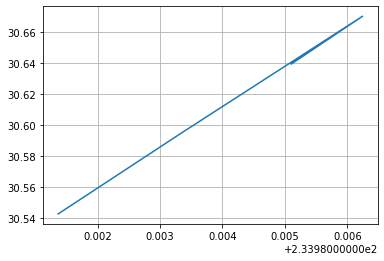

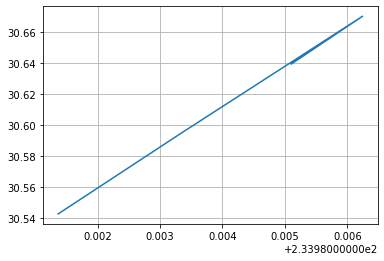

In [69]:
plt.cla()
# for stopping simulation with the esc key.
plt.gcf().canvas.mpl_connect(
    'key_release_event',
    lambda event: [exit(0) if event.key == 'escape' else None])
plt.plot(tx, ty)

plt.grid(True)

ipython_display.display(pl.gcf())

In [61]:
list(zip(tx,ty))[:10]

[(233.9813690185547, 30.542903900146484),
 (233.98337536316947, 30.595944549406024),
 (233.98626834117607, 30.67086952800211),
 (233.98505441641962, 30.638255954154996)]

In [28]:
list(zip(old_tx,old_ty))[:10]

[(233.9805450439453, 30.52267837524414),
 (233.98441434881505, 30.622603456344546),
 (233.9882875220851, 30.722528393418816),
 (233.99237334427914, 30.822441230370508),
 (233.9968308670352, 30.92233336023307),
 (234.0002687542481, 31.02227409032764),
 (234.00376407556823, 31.122212940282097),
 (234.00722580616636, 31.222152982336425),
 (234.0106868226242, 31.32209306051953),
 (234.01416836860838, 31.422032432240844)]

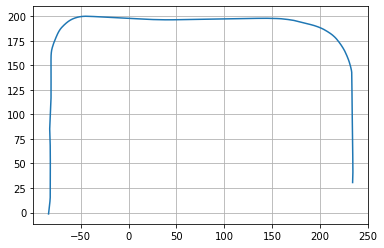

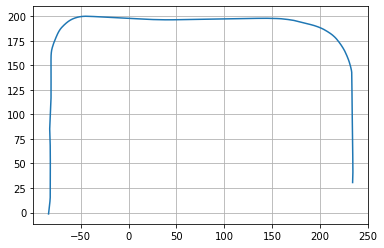

In [29]:
plt.cla()
# for stopping simulation with the esc key.
plt.gcf().canvas.mpl_connect(
    'key_release_event',
    lambda event: [exit(0) if event.key == 'escape' else None])
plt.plot(old_tx, old_ty)

plt.grid(True)

ipython_display.display(pl.gcf())

In [ ]:
# for fileName in drivesFileNames:
#     main(optimalDistance=optimalDistance,followDrivenPath=followDrivenPath,chaseMode=chaseMode, evaluateChasingCar=evaluateChasingCar,driveName=os.path.join(drivesDir,fileName),record=record,followMode=followMode)
